# pip install wordcloud

In [442]:
# pip install wordcloud

# import

In [535]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud

import ast  # Thêm thư viện này để parse string thành list

from sklearn.feature_extraction.text import CountVectorizer # Tạo n-grams
from sklearn.feature_extraction.text import TfidfVectorizer # Tính TF-IDF

# UIT_VSMEC

## Đọc dữ liệu sau tiền xử lý

In [601]:
preprocessed_uit = pd.read_csv("../data/preprocessed_data/preprocessed_uit.csv", encoding='utf-8-sig', on_bad_lines='skip')

**Do dữ liệu đã được tiền xử lý và lưu dưới dạng chuỗi, ta cần chuyển đổi chúng trở lại thành danh sách từ**

In [602]:
# Sử dụng hàm literal_eval để chuyển chuỗi thành danh sách
preprocessed_uit['Tokenized_Sentence'] = preprocessed_uit['Tokenized_Sentence'].apply(ast.literal_eval)

In [603]:
texts = preprocessed_uit['Tokenized_Sentence']

# Kiểm tra kiểu phần tử sau khi chuyển đổi
print("Kiểu phần tử:", type(texts.iloc[0]))
print("5 phần tử đầu tiên:", texts.iloc[:5].tolist())

Kiểu phần tử: <class 'list'>
5 phần tử đầu tiên: [['mình', 'xin', 'bài', 'nhạc', 'tên', 'gì', 'ạ'], ['đáng', 'đời', 'con', 'quỷ', 'về', 'nhà', 'lôi', 'con', 'nhà', 'mày', 'đánh', 'phẫn_nộ'], ['lo', 'học', 'yêu', 'đương cười_lớn', 'gì', 'hay', 'thích', 'học sinh', 'học'], ['ước', 'gì', 'sau này', 'về', 'già', 'vẫn', 'có thể', 'cụ', 'cười'], ['mỗi', 'lần', 'video', 'con', 'cứ', 'coi', 'coi', 'hoài', 'cưng', 'con']]


## Các tham số thống kê của bộ dữ liệu

### Tổng quan 

In [604]:
print("===== TỔNG QUAN BỘ DỮ LIỆU =====")
preprocessed_uit.describe()

===== TỔNG QUAN BỘ DỮ LIỆU =====


Sentence    Emotion  \
count                                                6183       6183   
unique                                               6183          7   
top     dume lũ mất dạy . bố mẹ cho mày ăn học để dơ n...  Enjoyment   
freq                                                    1       1754   

       Tokenized_Sentence  
count                6183  
unique               6166  
top           [nguy hiểm]  
freq                    5

In [605]:
print("=== SỐ GIÁ TRỊ NULL ===")
print((preprocessed_uit.isna()).sum())

=== SỐ GIÁ TRỊ NULL ===
Sentence              0
Emotion               0
Tokenized_Sentence    0
dtype: int64


Nhận xét: 
- Bộ dữ liệu UIT_VSMEC sau tiền xử lý gồm 6183 mẫu, và 7 nhãn cảm xúc
- Trong đó, nhãn Enjoyment chiếm số lượng nhiều nhất 
- Bộ dữ liệu không có các mẫu trùng lặp và giá trị khuyết

### Phân bố số lượng các nhãn (Emotion)

In [606]:
def analyze_class_imbalance(df, title_suffix="", target_col='Emotion', beta=0.9999):
    """
    Độ mất cân bằng dữ liệu toàn diện.
    
    Args:
        df: DataFrame chứa dữ liệu
        target_col: Tên cột nhãn (ví dụ 'Emotion')
        beta: Tham số cho Effective Number (thường là 0.99, 0.999 hoặc 0.9999)
    """
    # TÍNH TOÁN CÁC METRICS CƠ BẢN
    # ---------------------------------------------------------
    class_counts = df[target_col].value_counts().sort_values(ascending=False)
    total_samples = len(df)
    num_classes = len(class_counts)
    
    # Tạo DataFrame thống kê
    stats = pd.DataFrame({
        'Label': class_counts.index,
        'Count': class_counts.values
    })
    
    # Tính Tỷ lệ % (Percentage)
    stats['Percentage'] = (stats['Count'] / total_samples) * 100
    
    # Tính Imbalance Ratio (IR) = Số lượng lớp đa số / Số lượng lớp hiện tại
    # (IR càng cao chứng tỏ lớp đó càng bị lép vế so với lớp lớn nhất)
    majority_count = stats['Count'].max()
    stats['Imbalance Ratio (IR)'] = majority_count / stats['Count']
    
    # Tính Effective Number of Samples (En)
    # Công thức: (1 - beta^n) / (1 - beta)
    # Ý nghĩa: Đo lường lượng thông tin thực tế mà số lượng mẫu mang lại (bão hòa khi n lớn)
    stats['Effective Num'] = (1 - np.power(beta, stats['Count'])) / (1 - beta)
    
    # Hiển thị bảng thống kê
    print(f"MẤT CÂN BẰNG: {target_col}")
    print(f"Tổng số mẫu: {total_samples}")
    print(f"Số lượng nhãn: {num_classes}")
    print(f"Độ mất cân bằng toàn cục (Max/Min): {stats['Count'].max() / stats['Count'].min():.2f}")
    print("\nBảng chi tiết:")
    print(stats.to_string(index=False, float_format="%.2f"))

    # VISUALIZATION (TRỰC QUAN HÓA)

    # Lấy danh sách nhãn đã sắp xếp theo số lượng giảm dần (từ tập gốc)
    order_by_count = df[target_col].value_counts().index

    n_colors = len(order_by_count)
    # Dùng 'YlGnBu_r' (_r là reverse) nếu muốn nhãn nhiều nhất màu đậm nhất.
    consistent_colors = sns.color_palette('YlGnBu_r', n_colors)

    # Tạo từ điển ánh xạ: Tên Nhãn -> Màu cụ thể
    # Kết quả sẽ giống như: {'Enjoyment': (r,g,b), 'Other': (r,g,b), ...}
    color_mapping = dict(zip(order_by_count, consistent_colors))

    fig, axes = plt.subplots(figsize=(8, 7))

    sns.countplot(x=target_col, data=df, 
                order=order_by_count, palette=consistent_colors, ax=axes, alpha=0.7)
    axes.set_title(f'Số lượng mẫu từng nhãn ({len(df)} mẫu) {title_suffix}', fontweight='bold')
    axes.set_ylabel('Số mẫu')
    axes.set_xlabel('')
    # axes.tick_params(axis='x', rotation=20)
    axes.grid(axis='y', alpha=0.2)

    for i, p in enumerate(axes.patches):
            height = p.get_height()
            axes.text(p.get_x() + p.get_width() / 2., height + 8, 
                        f'{int(height)}', 
                        ha="center", fontsize=10, color='black', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    fig, axes = plt.subplots(figsize=(8, 7))
    
    # Biểu đồ 1: Pie Chart (Tỷ lệ phần trăm)
    # Tách miếng bé nhất ra một chút để dễ nhìn (explode)
    explode = [0.05 if c == stats['Count'].min() else 0 for c in stats['Count']]

    pie_colors = [color_mapping[label] for label in stats['Label']]
    
    axes.pie(stats['Count'], labels=stats['Label'], autopct='%1.1f%%', 
                startangle=140, colors=pie_colors, explode=explode,
                pctdistance=0.85, wedgeprops=dict(width=0.5))
    axes.set_title(f'Tỷ lệ phân bố các nhãn {target_col} {title_suffix}', fontweight='bold', fontsize=14)
    
    # Thêm số tổng ở giữa biểu đồ tròn
    axes.text(0, 0, f"Total\n{total_samples}", ha='center', va='center', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

MẤT CÂN BẰNG: Emotion
Tổng số mẫu: 6183
Số lượng nhãn: 7
Độ mất cân bằng toàn cục (Max/Min): 6.50

Bảng chi tiết:
    Label  Count  Percentage  Imbalance Ratio (IR)  Effective Num
Enjoyment   1754       28.37                  1.00        1608.86
  Disgust   1192       19.28                  1.47        1123.75
    Other   1158       18.73                  1.51        1093.52
  Sadness   1027       16.61                  1.71         976.07
    Anger    436        7.05                  4.02         426.65
     Fear    346        5.60                  5.07         340.10
 Surprise    270        4.37                  6.50         266.40


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\1924038689.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_col, data=df,


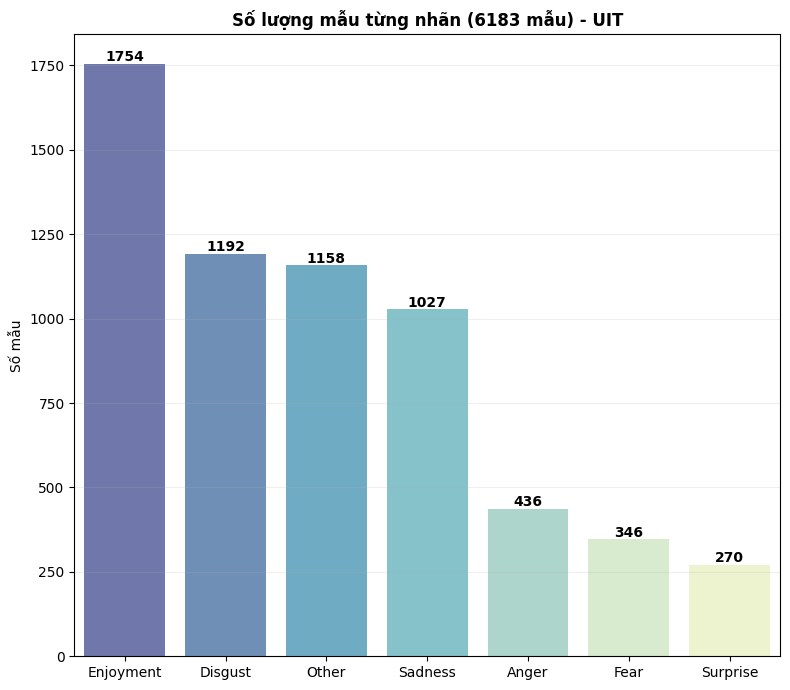

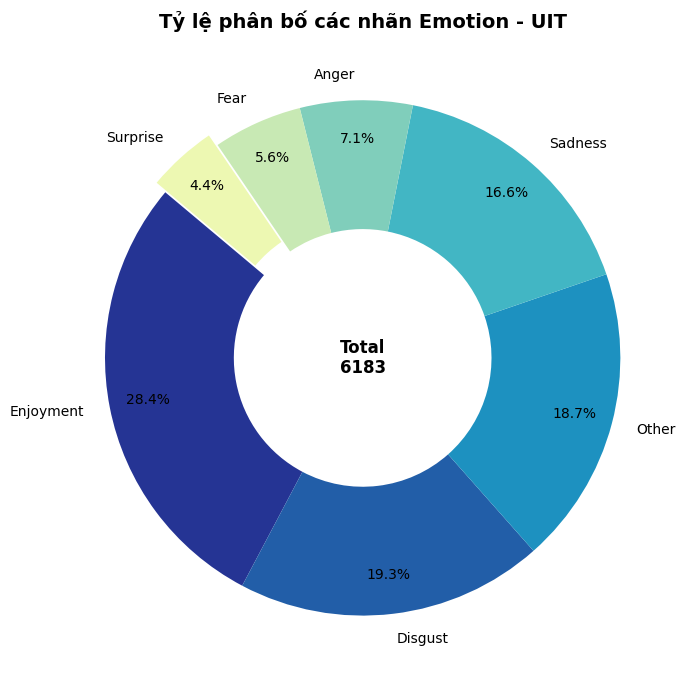

In [607]:
analyze_class_imbalance(preprocessed_uit, title_suffix="- UIT", target_col='Emotion')

### Phân tích số lượng token trong một câu

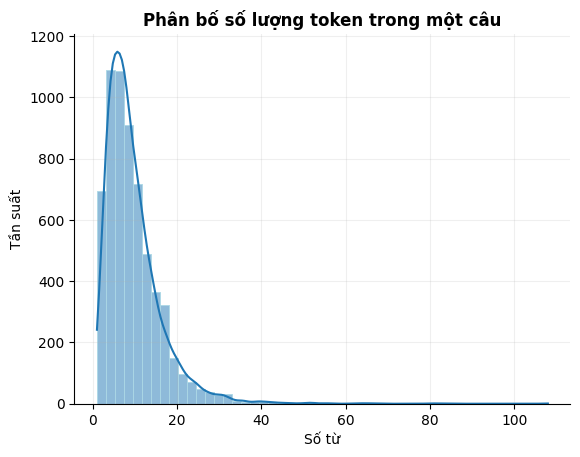

In [608]:
preprocessed_uit['tokens_length'] = preprocessed_uit['Tokenized_Sentence'].apply(lambda x: len(x))

sns.histplot(preprocessed_uit['tokens_length'], bins=50, edgecolor = 'lightblue', kde=True)    # bins: kc cách đều
sns.despine(top=True, right=True)
plt.title("Phân bố số lượng token trong một câu", fontweight = 'bold')
plt.xlabel("Số từ")
plt.ylabel("Tần suất")
plt.grid(alpha = 0.2)
plt.show()

In [609]:
print("THAM SỐ THỐNG KÊ CỘT tokens_length")
preprocessed_uit.describe()

THAM SỐ THỐNG KÊ CỘT tokens_length


tokens_length
count    6183.000000
mean        9.547307
std         6.783760
min         1.000000
25%         5.000000
50%         8.000000
75%        12.000000
max       108.000000

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\702278627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Emotion', y='tokens_length', data=preprocessed_uit, palette='Spectral')


<Axes: xlabel='Emotion', ylabel='tokens_length'>

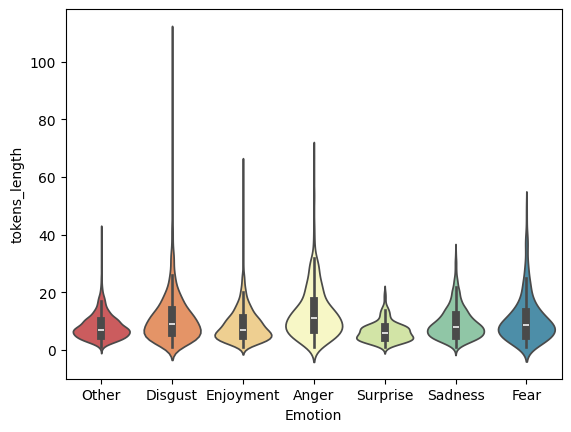

In [610]:
# Boxplot độ dài token theo từng nhãn
# sns.boxplot(x='Emotion', y='tokens_length', data=preprocessed_uit)
# Hoặc violin plot để thấy phân phối chi tiết hơn
sns.violinplot(x='Emotion', y='tokens_length', data=preprocessed_uit, palette='Spectral')

In [611]:
def inspect_length_outliers(df, text_col='Tokenized_Sentence', label_col='Emotion', n_show=5):
    """
    Hàm tìm và hiển thị các câu có độ dài token lớn nhất và nhỏ nhất.
    
    Args:
        df: DataFrame đầu vào
        text_col: Tên cột chứa văn bản (đã tách từ hoặc chưa)
        label_col: Tên cột nhãn
        n_show: Số lượng câu muốn hiển thị ở mỗi nhóm
    """
    max_len = df['tokens_length'].max()
    min_len = df['tokens_length'].min()

    # Hiển thị TOP câu DÀI NHẤT
    print(f"TOP {n_show} CÂU DÀI NHẤT:")
    long_samples = df[df['tokens_length'] == max_len]
    
    # Nếu số lượng câu max quá ít, lấy thêm các câu gần max
    if len(long_samples) < n_show:
        long_samples = df.nlargest(n_show, 'tokens_length')
        
    for idx, row in long_samples.head(n_show).iterrows():
        print(f"[Dòng {idx}] - [{row[label_col]}] - Độ dài: {row['tokens_length']}")
        print(f"Nội dung: {row[text_col]}")
        print(f"Câu văn đầy đủ - cột Sentence: {row['Sentence']}")
        print("---")

    # Hiển thị TOP câu NGẮN NHẤT
    print(f"\nTOP {n_show} CÂU NGẮN NHẤT:")
    short_samples = df[df['tokens_length'] == min_len]
    
    # Nếu số lượng câu min quá nhiều (thường là vậy), chỉ lấy ngẫu nhiên để xem
    if len(short_samples) > n_show:
        short_samples = short_samples.sample(n=n_show, random_state=42)
    elif len(short_samples) < n_show:
        short_samples = df.nsmallest(n_show, 'tokens_length')
        
    for idx, row in short_samples.head(n_show).iterrows():
        print(f"[Dòng {idx}] - [{row[label_col]}] - Độ dài: {row['tokens_length']}")
        print(f"Nội dung: {row[text_col]}")
        print(f"Câu văn đầy đủ - cột Sentence: {row['Sentence']}")
        print("---")

In [612]:
inspect_length_outliers(preprocessed_uit, text_col='Tokenized_Sentence')

TOP 5 CÂU DÀI NHẤT:
[Dòng 1029] - [Disgust] - Độ dài: 108
Nội dung: ['tôi', 'kể', 'bạn', 'nghe', '1', 'chuyện', 'dính', '1', 'tý', 'caphe', 'tn', 'chuyện', 'thế này', 'ba', 'vợ', 'tôi', '1', 'người', 'bạn', 'khó', 'khắn', 'nghèo', 'trốn', 'nợ', 'ba', 'tôi', 'ông', 'chiếc', 'xe máy', 'củ', 'để', 'xe ôm', 'vợ chồng', 'ông', 'bạn', 'bỏ', 'quê', 'trốn', 'nợ', 'lên', 'tây nguyên', 'làm công', 'nhà máy', 'caphe', 'tn', '4', 'năm học', 'nghề', 'làm', 'caphe', 'sáng lập', 'caphe tuấn', 'kiệt caphe', 'công thức', 'y chang', 'tn', 'bán', 'hợp lý', 'hơn', '!', 'ngày nay', 'ông', 'chủ', 'tuấn kiệt', '1', 'đại gia', 'nhà máy', 'sốc trăng', 'ông', 'ấy', 'tìm', 'trả', 'nợ', 'từng', 'người', 'ơn', 'mình', '!', 'mổi', 'lần', 'ba', 'tôi', 'lên', 'sg', 'ông', 'đều', 'xe', 'tới', 'mời', 'ba', 'tôi', 'ăn nhậu', '!', 'lúc', 'ngà ngà', 'ông', 'ấy', 'nói', 'em', 'chả', 'bao giờ', 'uống', 'caphe', 'em', 'làm', 'tn', 'cũng', 'thế']
Câu văn đầy đủ - cột Sentence: tôi kể các bạn nghe 1 chuyện có dính 1 tý với cap

## Loại bỏ outlier 

In [613]:
# # Tính Q1, Q3 và IQR
# Q1 = preprocessed_uit['tokens_length'].quantile(0.25)    
# Q3 = preprocessed_uit['tokens_length'].quantile(0.75)

# IQR = Q3 - Q1

# # Tính giới hạn trên, dưới
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# print(f"Q1 = {Q1}, Q3 = {Q3}, IQR = {IQR}")
# print(f"Ngưỡng dưới: {lower_bound}, ngưỡng trên: {upper_bound}")

ngưỡng trên là 22.5, nhưng mà model vẫn có thể nhận biết tốt với số từ lớn hơn nx :<

nên hiện tại cmt đoạn này lại :<

Nhận xét: tỉ lệ các nhãn không thay đổi quá nhiều sau khi loại bỏ outlier

## Trực quan hóa

In [614]:
preprocessed_uit.head(5)

Sentence    Emotion  \
0              cho mình xin bài nhạc tên là gì với ạ      Other   
1  cho đáng đời con quỷ . về nhà lôi con nhà mày ...    Disgust   
2  lo học đi . yêu đương cười_lớn gì hay lại thíc...    Disgust   
3   ước gì sau này về già vẫn có thể như cụ này cười  Enjoyment   
4  mỗi lần có video của con là cứ coi đi coi lại ...  Enjoyment   

                                  Tokenized_Sentence  tokens_length  
0                 [mình, xin, bài, nhạc, tên, gì, ạ]              7  
1  [đáng, đời, con, quỷ, về, nhà, lôi, con, nhà, ...             12  
2  [lo, học, yêu, đương cười_lớn, gì, hay, thích,...              9  
3  [ước, gì, sau này, về, già, vẫn, có thể, cụ, c...              9  
4  [mỗi, lần, video, con, cứ, coi, coi, hoài, cưn...             10

### Tần suất từ tổng thể

Ảnh này show ra sau bước tiền xử lý loại từ dừng

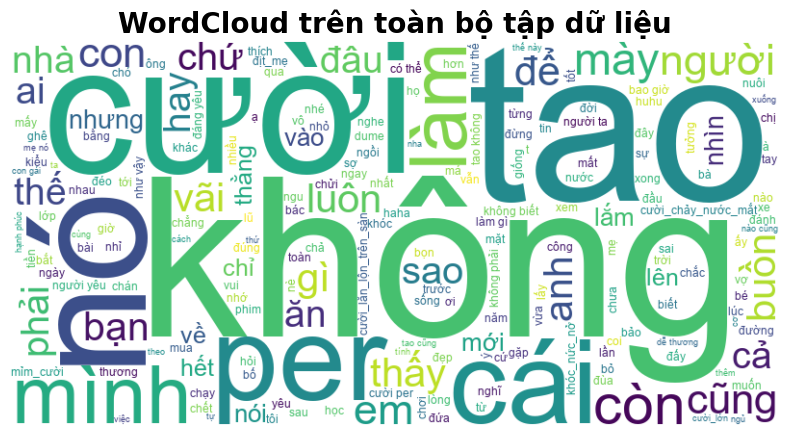

In [665]:
# Join lại
all_words = " ".join([" ".join(tokens) if isinstance(tokens, list) else tokens 
                     for tokens in preprocessed_uit['Tokenized_Sentence']])
# Tạo WordCloud
wc = WordCloud(font_path='arial',
               background_color='white',
               width=800, height=400,
               colormap='viridis').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud trên toàn bộ tập dữ liệu",
          fontsize=20,
          fontweight='bold')
plt.show()

Nhận xét: Do enjoyment và icon nhiều nên chữ cười có tần suất xuất hiện nhiều nhất 

### Tần suất từ theo từng nhãn

In [666]:
def create_wordcloud_per_emotion(df, title_suffix="", token_col='Tokenized_Sentence', colormap='viridis'):
    """
    Tạo WordCloud cho từng nhãn cảm xúc
    """
    emotions = df['Emotion'].unique()
    
    for emotion in emotions:
        emotion_data = df[df['Emotion'] == emotion]
        all_words = " ".join([" ".join(tokens) if isinstance(tokens, list) else tokens 
                            for tokens in emotion_data[token_col]])
        
        wc = WordCloud(font_path='arial', background_color='white',
                      width=800, height=400, colormap=colormap).generate(all_words)
        
        plt.figure(figsize=(8, 6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud {title_suffix} - {emotion}", fontsize=15, fontweight='bold')
        plt.show()

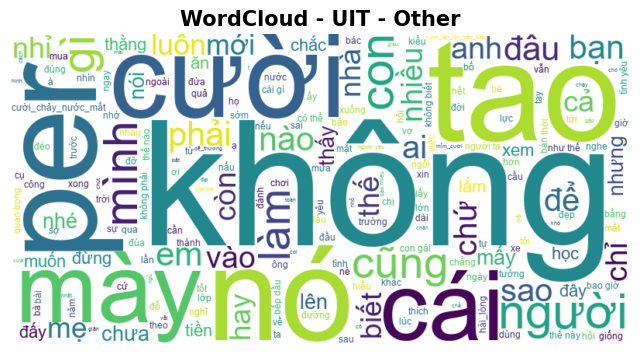

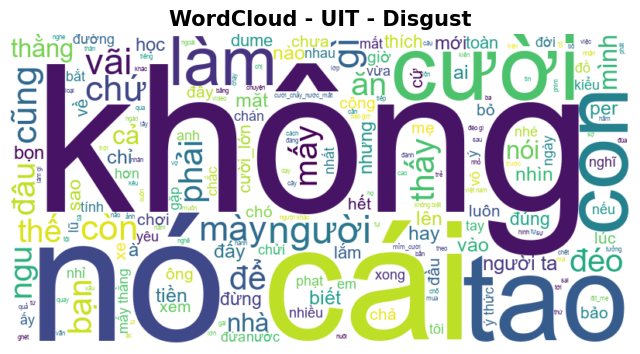

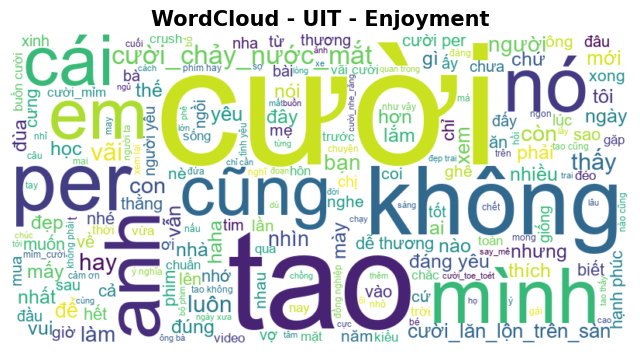

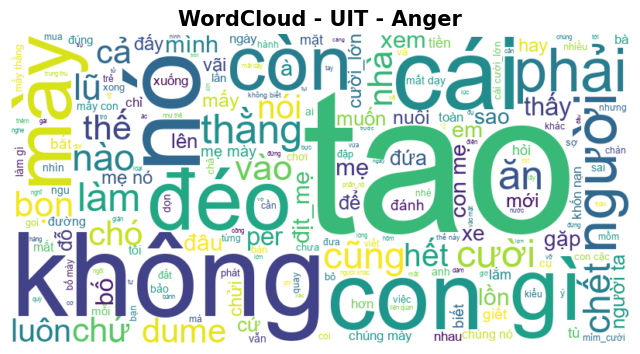

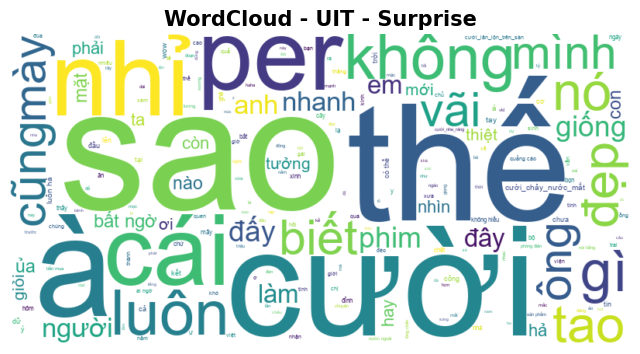

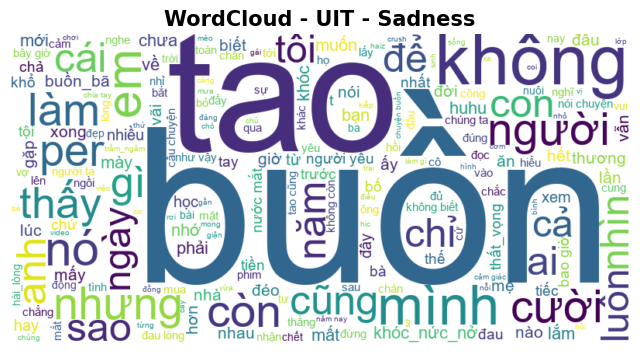

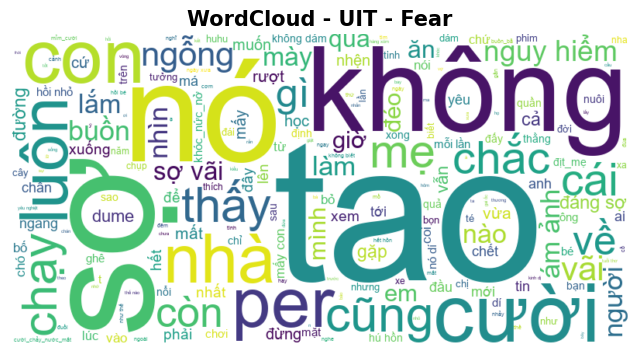

In [667]:
create_wordcloud_per_emotion(preprocessed_uit, title_suffix="- UIT")

### Phân bố số lượng token theo từng nhãn

In [618]:
def analyze_token_length_by_emotion(df_pre, bins=[0, 5, 10, 20, 40, 1000], 
                                     labels=['1-5', '6-10', '11-20', '21-40', '>40']):
    """
    Phân tích và trực quan hóa độ dài token theo từng nhãn
    """
    df = df_pre.copy()
    order_by_count = df['Emotion'].value_counts().index
    
    # Thống kê
    stats = df.groupby('Emotion')['tokens_length'].describe()
    print("THỐNG KÊ ĐỘ DÀI TOKEN THEO NHÃN")
    print(stats)
    
    # Phân nhóm độ dài
    # labels = ['1-5 (Cực kỳ ngắn)', '6-10 (Rất ngắn)', '11-20 (Ngắn)', '21-40 (Vừa phải)', '> 40 (Dài)']
    df['len_group'] = pd.cut(df['tokens_length'], bins=bins, labels=labels)
    
    pivot_table = pd.crosstab(df['len_group'], df['Emotion'])
    
    # Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Heatmap: Số lượng mẫu theo Nhóm độ dài & Cảm xúc', fontweight='bold')
    plt.xlabel('Emotion')
    plt.ylabel('Nhóm độ dài token')
    plt.show()

    # Vẽ biểu đồ Stacked Bar để xem tỷ lệ %
    pivot_percent = pd.crosstab(df['Emotion'], df['len_group'], normalize='index') * 100
    pivot_percent = pivot_percent.loc[order_by_count] # Sắp xếp lại thứ tự

    pivot_percent.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='YlGnBu')
    plt.title('Tỷ lệ % các nhóm độ dài trong từng cảm xúc', fontweight='bold')
    plt.ylabel('Tỷ lệ (%)')
    plt.xlabel('Emotion')
    plt.legend(title='Độ dài', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

THỐNG KÊ ĐỘ DÀI TOKEN THEO NHÃN
            count       mean       std  min   25%   50%   75%    max
Emotion                                                             
Anger       436.0  12.788991  8.708377  1.0  7.00  11.0  17.0   67.0
Disgust    1192.0  11.310403  9.225105  1.0  5.75   9.0  14.0  108.0
Enjoyment  1754.0   8.697263  5.700364  1.0  5.00   7.0  11.0   64.0
Fear        346.0  10.768786  8.084249  1.0  5.00   8.5  13.0   50.0
Other      1158.0   8.246114  4.337417  1.0  5.00   7.0  10.0   41.0
Sadness    1027.0   9.444012  5.511244  1.0  5.00   8.0  12.0   34.0
Surprise    270.0   6.459259  3.388726  1.0  4.00   6.0   8.0   20.0


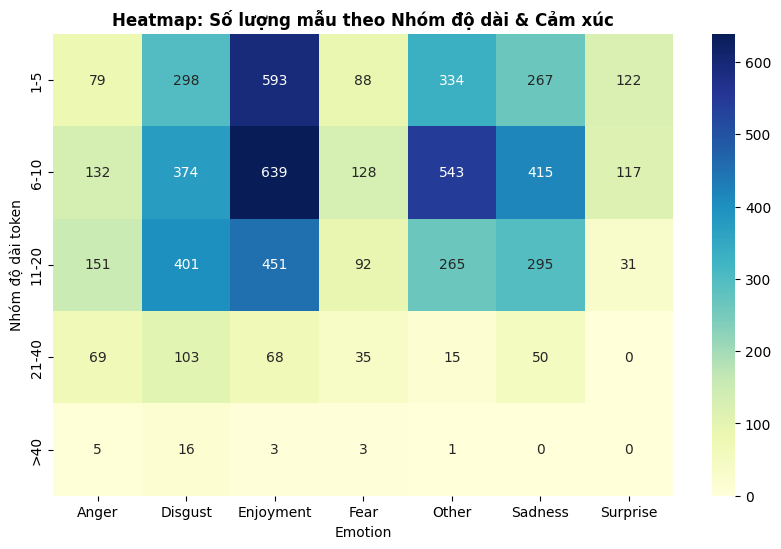

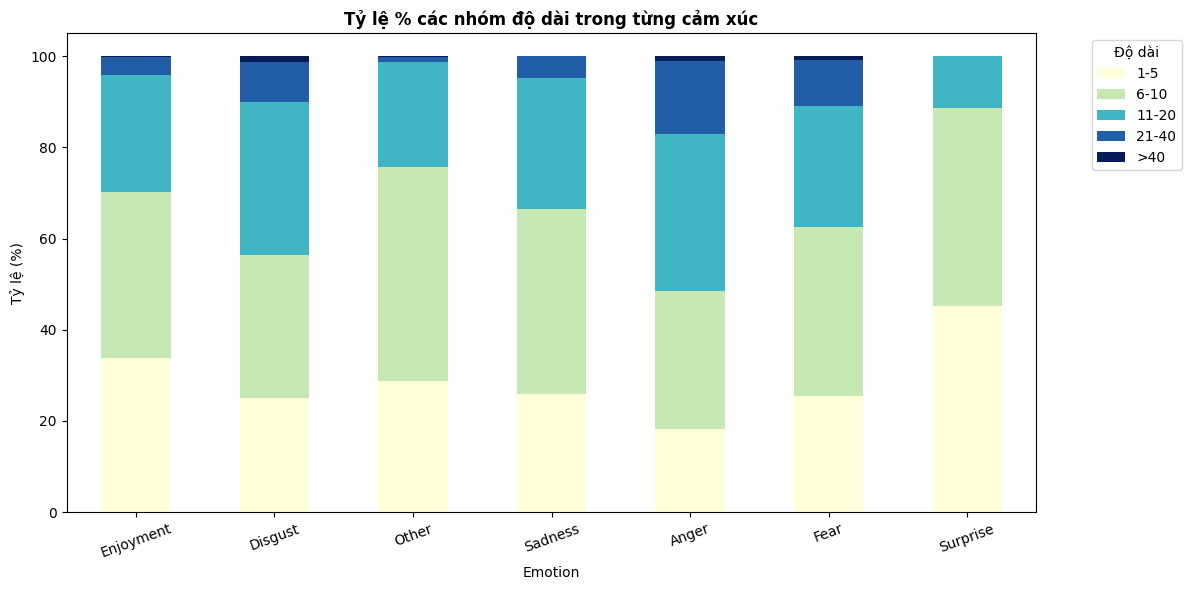

In [619]:
analyze_token_length_by_emotion(preprocessed_uit)

### Phân tích từ vựng: N-grams và TF-IDF keywords

#### N-grams: Bigram & Trigram

In [620]:
def plot_top_ngrams(corpus, n=2, top_k=10, title="Top n-grams"):
    """
    Hàm vẽ biểu đồ Top K n-grams phổ biến nhất
    n=2: Bigram, n=3: Trigram
    """
    # Khởi tạo vectorizer để đếm
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    
    # Tính tổng số lần xuất hiện của mỗi n-gram
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    # Sắp xếp giảm dần và lấy top k
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]
    
    # Chuyển thành DataFrame để vẽ
    df_ngram = pd.DataFrame(words_freq, columns=['Ngram', 'Count'])
    
    # Vẽ biểu đồ
    plt.figure(figsize=(7, 5))
    sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')
    plt.title(title, fontweight='bold')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-gram')
    plt.tight_layout()
    plt.show()

In [621]:
def analyze_ngrams_per_emotion(df, title_suffix="", sentence_col='Sentence', n_values=[2, 3], top_k=10):
    """
    Phân tích N-grams cho từng nhãn
    """
    labels = df['Emotion'].unique()
    for label in labels:
        print(f"\nPhân tích cho nhãn: {label}")
        subset = df[df['Emotion'] == label][sentence_col]
        
        for n in n_values:
            plot_top_ngrams(subset, n=n, top_k=top_k, 
                          title=f"Top {top_k} {n}-grams - {label} - {title_suffix}")


Phân tích cho nhãn: Other


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


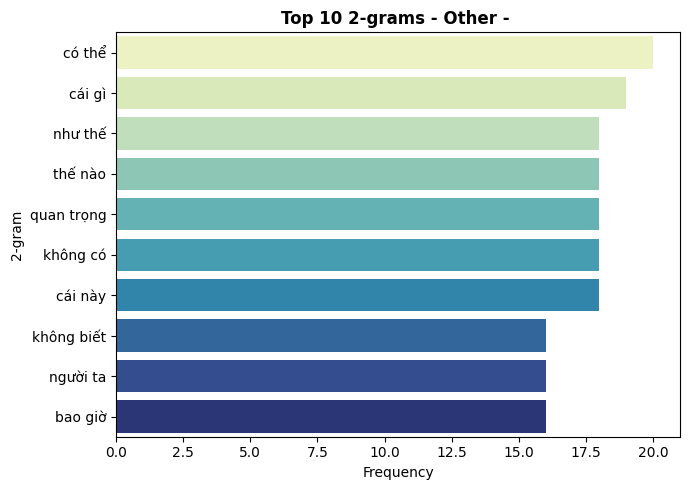

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


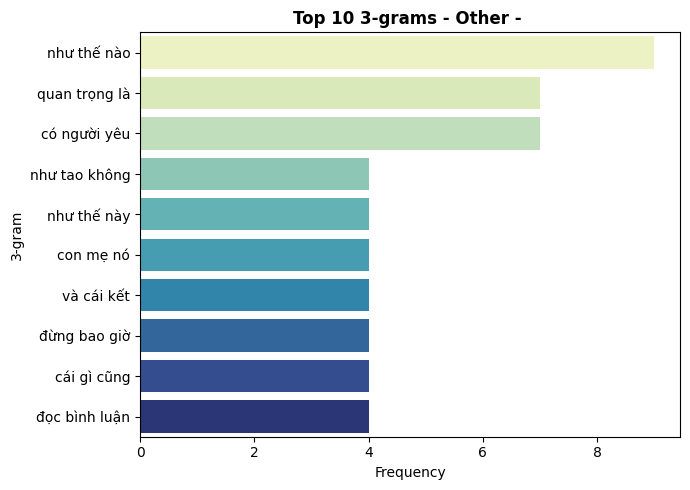


Phân tích cho nhãn: Disgust


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


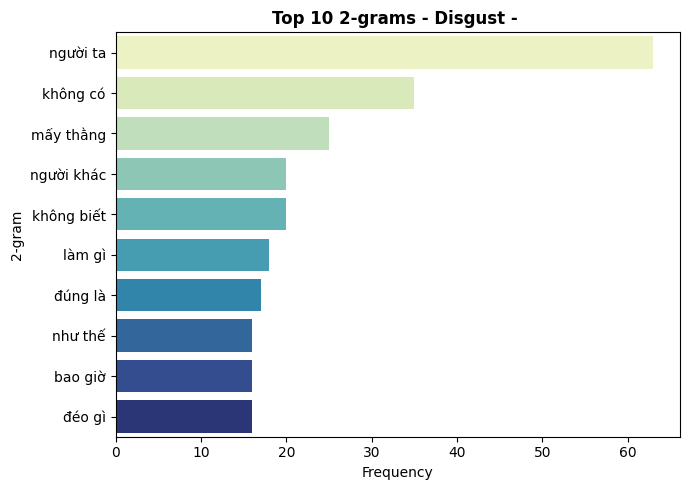

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


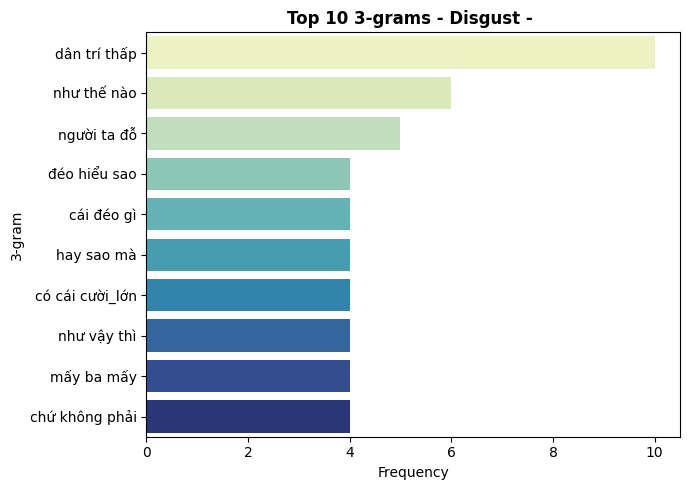


Phân tích cho nhãn: Enjoyment


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


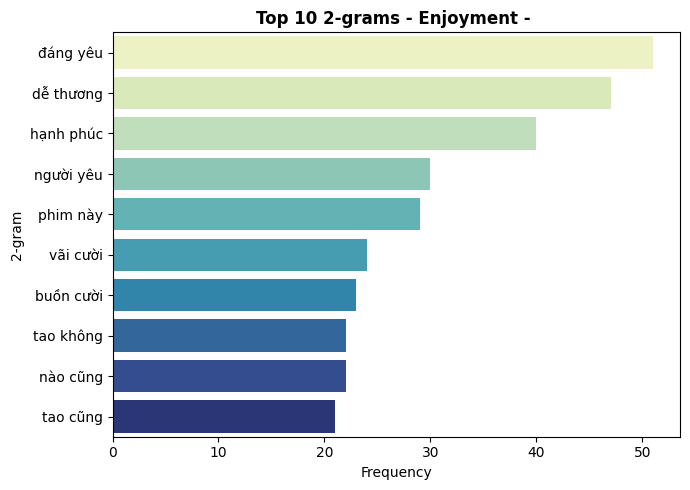

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


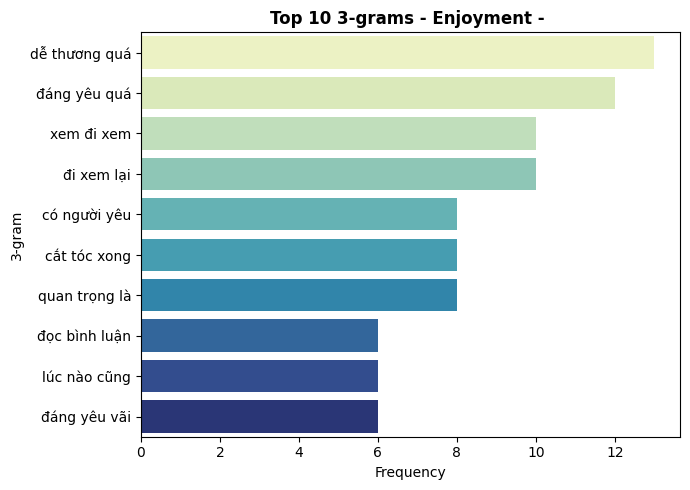


Phân tích cho nhãn: Anger


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


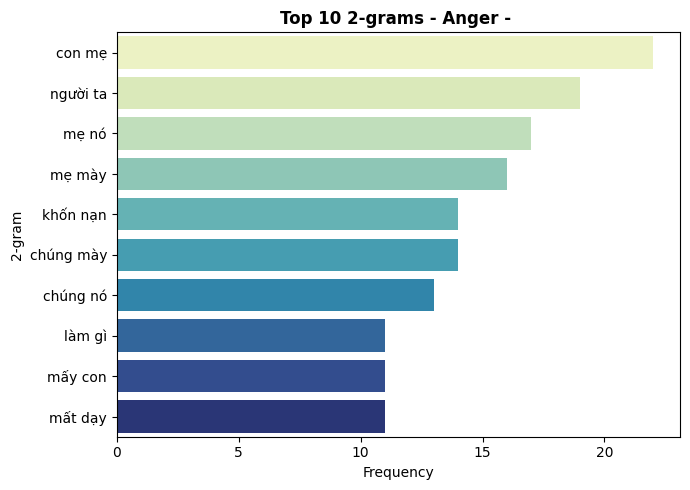

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


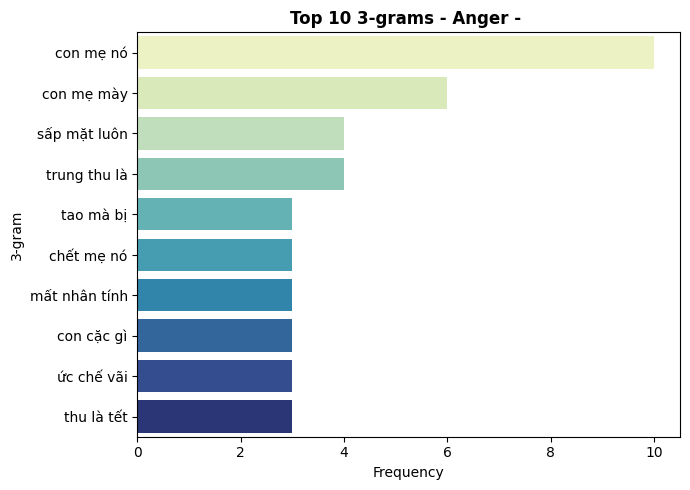


Phân tích cho nhãn: Surprise


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


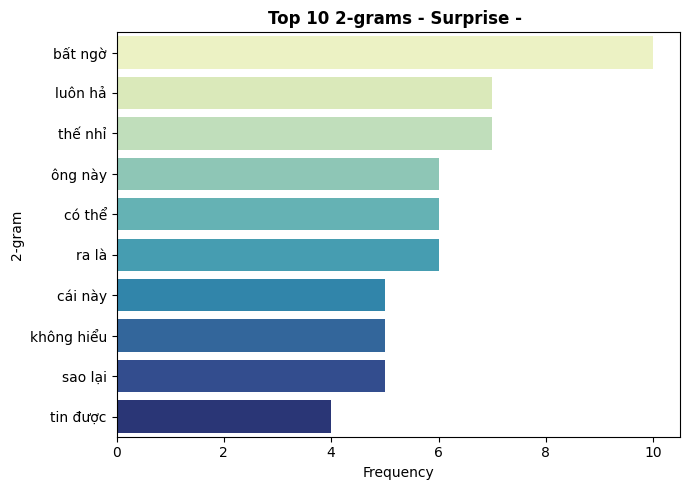

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


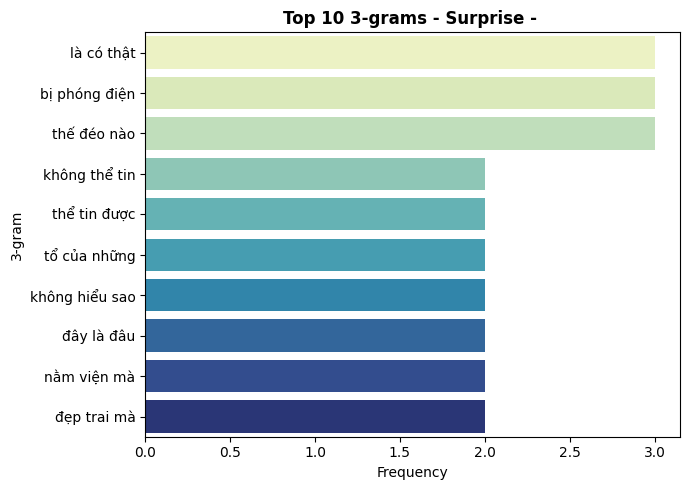


Phân tích cho nhãn: Sadness


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


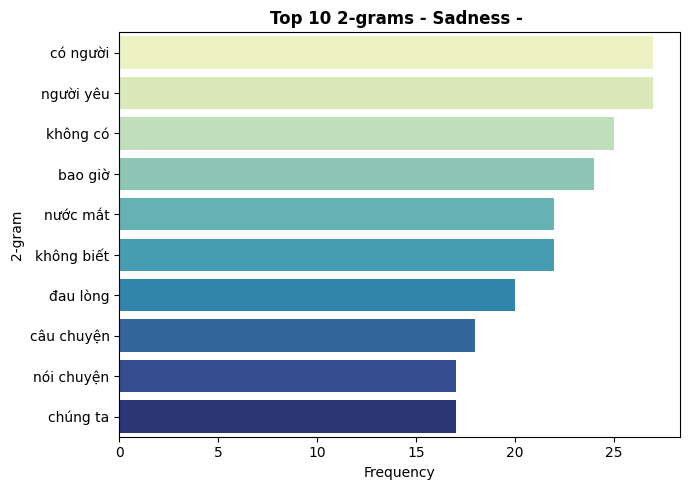

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


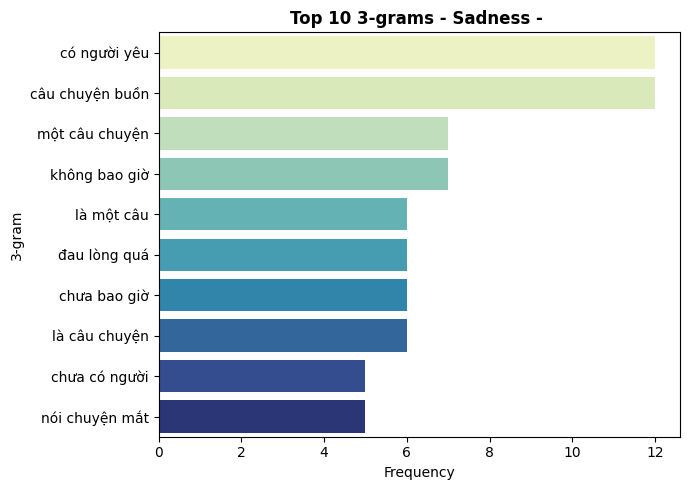


Phân tích cho nhãn: Fear


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


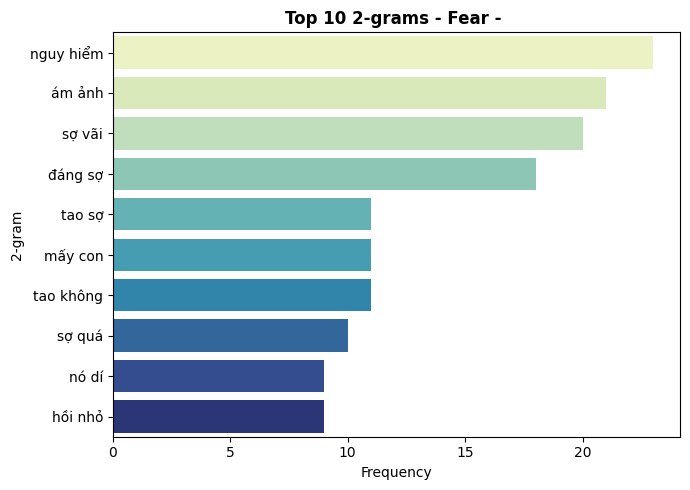

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


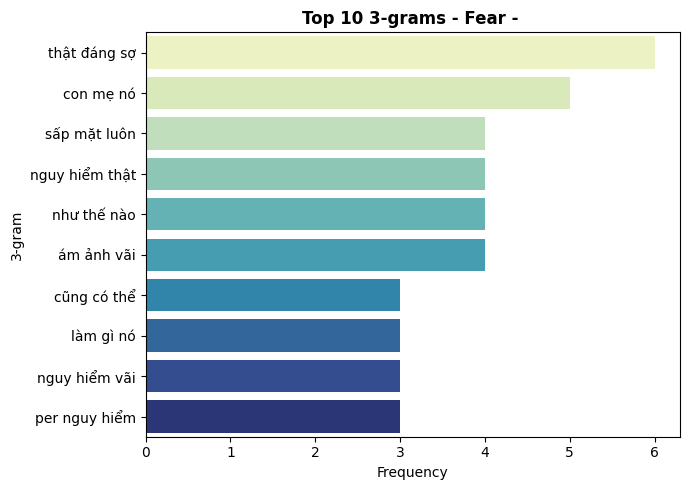

In [622]:
analyze_ngrams_per_emotion(preprocessed_uit, sentence_col='Sentence', n_values=[2, 3], top_k=10)

#### TF-IDF keysword

In [623]:
def get_top_tfidf_keywords(row_idx, top_n=10):
    # Chuyển về dạng dense array để xử lý
    row_data = tfidf_matrix[row_idx].toarray().flatten()
    # Lấy index của top n điểm cao nhất
    top_indices = row_data.argsort()[-top_n:][::-1]
    
    return [(feature_names[i], row_data[i]) for i in top_indices]

In [624]:
def analyze_tfidf_per_emotion(df, sentence_col='Sentence', top_n=5):
    """
    Phân tích TF-IDF keywords cho từng nhãn
    """
    # Gop van ban theo tung nhom Emotion
    grouped_df = df.groupby('Emotion')[sentence_col].apply(lambda x: ' '.join(x)).reset_index()
    
    tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    tfidf_matrix = tfidf.fit_transform(grouped_df[sentence_col])
    feature_names = tfidf.get_feature_names_out()
    
    print("TOP TỪ KHÓA ĐẶC TRƯNG (TF-IDF) CHO TỪNG NHÃN")
    for idx, row in grouped_df.iterrows():
        emotion = row['Emotion']
        keywords = get_top_tfidf_keywords(idx, top_n)
        print(f"\nLabel: {emotion.upper()}")
        for kw, score in keywords:
            print(f"  - {kw}: {score:.4f}")

In [625]:
analyze_tfidf_per_emotion(preprocessed_uit, sentence_col='Sentence', top_n=5)

TOP TỪ KHÓA ĐẶC TRƯNG (TF-IDF) CHO TỪNG NHÃN

Label: ANGER
  - không: 0.2830
  - thì: 0.2320
  - nó: 0.1951
  - cho: 0.1846
  - mà: 0.1811

Label: DISGUST
  - không: 0.3224
  - là: 0.2298
  - thì: 0.2242
  - này: 0.2149
  - cười: 0.2020

Label: ENJOYMENT
  - cười: 0.3065
  - không: 0.2715
  - tôi: 0.2338
  - cười_lăn_lộn_trên_sàn: 0.2246
  - là: 0.1960

Label: FEAR
  - không: 0.3444
  - sợ: 0.3346
  - đi: 0.2067
  - đường: 0.1785
  - nó: 0.1771

Label: OTHER
  - không: 0.4154
  - là: 0.2861
  - có: 0.2498
  - tôi: 0.2324
  - thì: 0.1874

Label: SADNESS
  - di đà: 0.2339
  - di: 0.2339
  - đà phật: 0.2291
  - không: 0.2240
  - tôi: 0.2140

Label: SURPRISE
  - vậy: 0.3650
  - sao: 0.2351
  - mà: 0.2103
  - cười: 0.2041
  - là: 0.1794


# HUS_FB

## Đọc dữ liệu sau tiền xử lý

In [626]:
preprocessed_hus_fb = pd.read_csv("../data/preprocessed_data/preprocessed_hus_fb.csv", encoding='utf-8-sig', on_bad_lines='skip')

**Do dữ liệu đã được tiền xử lý và lưu dưới dạng chuỗi, ta cần chuyển đổi chúng trở lại thành danh sách từ**

In [627]:
# Sử dụng hàm literal_eval để chuyển chuỗi thành danh sách
preprocessed_hus_fb['Tokenized_Sentence'] = preprocessed_hus_fb['Tokenized_Sentence'].apply(ast.literal_eval)

In [628]:
texts = preprocessed_hus_fb['Tokenized_Sentence']

# Kiểm tra kiểu phần tử sau khi chuyển đổi
print("Kiểu phần tử:", type(texts.iloc[0]))
print("5 phần tử đầu tiên:", texts.iloc[:5].tolist())

Kiểu phần tử: <class 'list'>
5 phần tử đầu tiên: [['xin lỗi', 'chứ', 'loại', 'tôi', 'đéo', 'bao giờ', 'chơi', 'lần', '2', 'éo', 'hiểu', 'vui', 'gì', 'giỡn', 'gì', 'tới', 'lúc', '3', 'mặt', '1', 'lời', 'con', 'nói xấu', 'nó', 'đánh', 'mình', 'chắc', 'nhỏ', 'cũng', 'đứng', 'cười'], ['sợ', 'đánh', 'đừng', 'nói', 'cười'], ['sợ', 'đừng', 'nói', 'cười', 'bản lĩnh', 'cái', 'thằng', 'đàn ông', 'nói', 'chịu'], ['chắc', 'cuộc đời', 'mày', 'chưa', 'bao giờ', 'nói xấu', 'ai', 'chứ', 'vô chùa', 'ta', 'nói', 'không', 'biết', 'phải', 'lạy', 'ai', 'luôn', 'yêu_thương'], ['biết', 'nhưng', 'cái', 'mỏ', 'nó', 'giật', 'lắm', 'mày', 'cười_lăn_lộn_trên_sàn', 'chúng nó', 'cũng', 'nói xấu', 'tôi', 'qua', 'toại lòng', 'nhau', 'haha']]


## Các tham số thống kê của bộ dữ liệu

### Tổng quan 

In [629]:
print("===== TỔNG QUAN BỘ DỮ LIỆU =====")
preprocessed_hus_fb.describe()

===== TỔNG QUAN BỘ DỮ LIỆU =====


Sentence    Emotion  \
count                                                4521       4521   
unique                                               4521          7   
top     đảm bảo an sinh xã hội công bằng cho tất cả mọ...  Enjoyment   
freq                                                    1       1756   

       Tokenized_Sentence  
count                4521  
unique               4497  
top           [dễ thương]  
freq                    6

In [630]:
print("=== SỐ GIÁ TRỊ NULL ===")
print((preprocessed_hus_fb.isna()).sum())

=== SỐ GIÁ TRỊ NULL ===
Sentence              0
Emotion               0
Tokenized_Sentence    0
dtype: int64


Nhận xét: 
- Bộ dữ liệu HUS_FB sau tiền xử lý gồm 4521 mẫu, và 7 nhãn cảm xúc
- Trong đó, nhãn Enjoyment chiếm số lượng nhiều nhất 
- Bộ dữ liệu không có các mẫu trùng lặp và giá trị khuyết

### Phân bố số lượng các nhãn (Emotion)

MẤT CÂN BẰNG: Emotion
Tổng số mẫu: 4521
Số lượng nhãn: 7
Độ mất cân bằng toàn cục (Max/Min): 14.28

Bảng chi tiết:
    Label  Count  Percentage  Imbalance Ratio (IR)  Effective Num
Enjoyment   1756       38.84                  1.00        1610.54
    Other    860       19.02                  2.04         824.10
  Disgust    616       13.63                  2.85         597.44
  Sadness    445        9.84                  3.95         435.27
    Anger    428        9.47                  4.10         418.99
 Surprise    293        6.48                  5.99         288.76
     Fear    123        2.72                 14.28         122.25


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\1924038689.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_col, data=df,


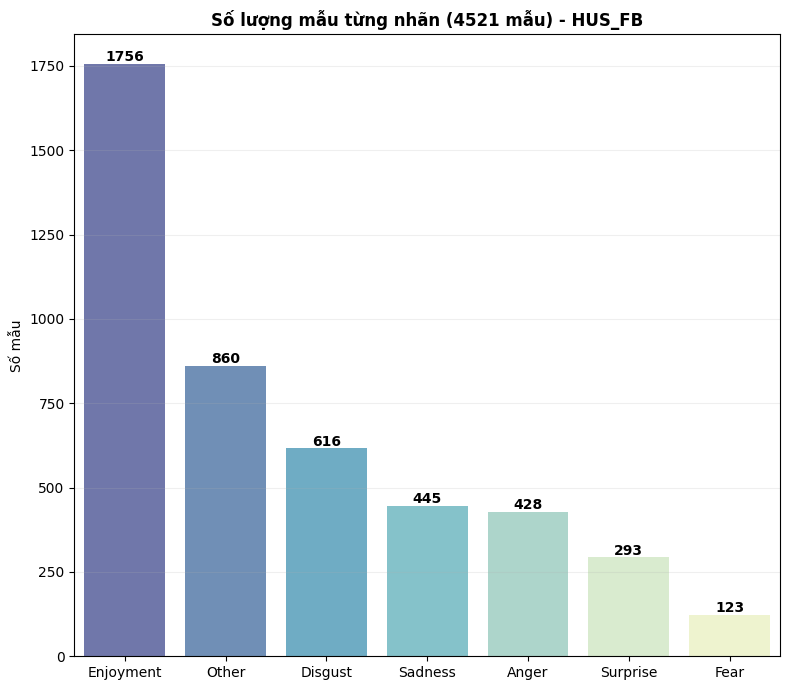

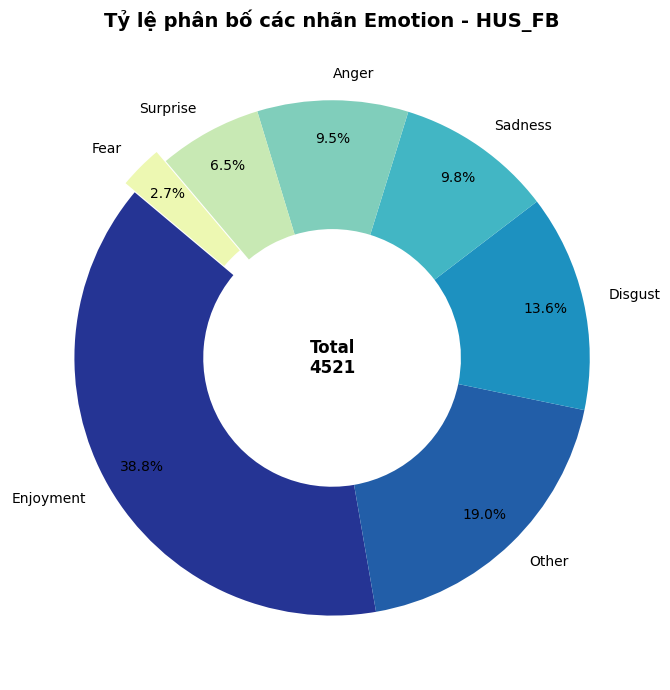

In [631]:
analyze_class_imbalance(preprocessed_hus_fb, title_suffix="- HUS_FB", target_col='Emotion')

### Phân tích số lượng token trong một câu

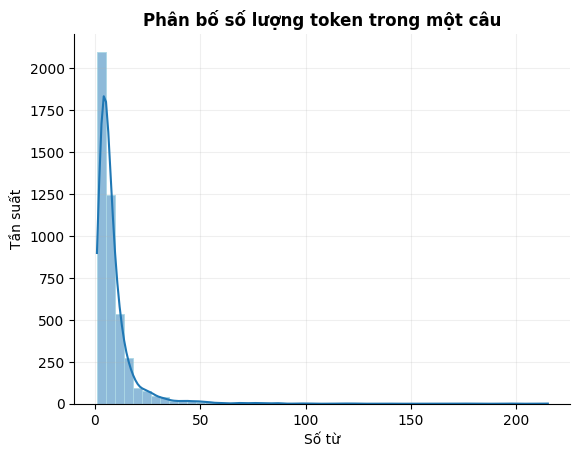

In [632]:
preprocessed_hus_fb['tokens_length'] = preprocessed_hus_fb['Tokenized_Sentence'].apply(lambda x: len(x))

sns.histplot(preprocessed_hus_fb['tokens_length'], bins=50, edgecolor = 'lightblue', kde=True)    # bins: kc cách đều
sns.despine(top=True, right=True)
plt.title("Phân bố số lượng token trong một câu", fontweight = 'bold')
plt.xlabel("Số từ")
plt.ylabel("Tần suất")
plt.grid(alpha = 0.2)
plt.show()

In [633]:
print("THAM SỐ THỐNG KÊ CỘT tokens_length")
preprocessed_hus_fb.describe()

THAM SỐ THỐNG KÊ CỘT tokens_length


tokens_length
count    4521.000000
mean        8.792081
std        11.374873
min         1.000000
25%         4.000000
50%         6.000000
75%        10.000000
max       215.000000

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\1289538463.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Emotion', y='tokens_length', data=preprocessed_hus_fb, palette='Spectral')


<Axes: xlabel='Emotion', ylabel='tokens_length'>

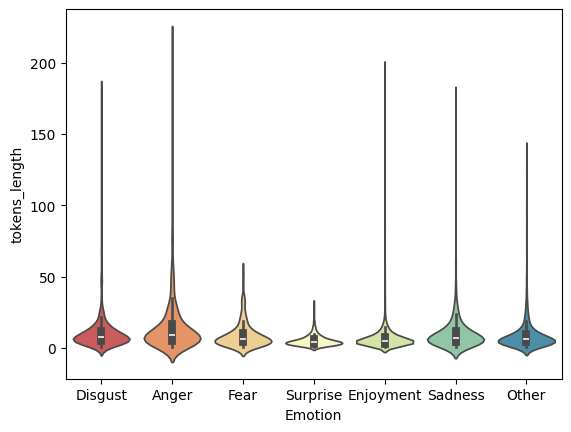

In [634]:
sns.violinplot(x='Emotion', y='tokens_length', data=preprocessed_hus_fb, palette='Spectral')

In [635]:
inspect_length_outliers(preprocessed_hus_fb, text_col='Tokenized_Sentence')

TOP 5 CÂU DÀI NHẤT:
[Dòng 2066] - [Anger] - Độ dài: 215
Nội dung: ['ê', 'quan điểm', 'tao', 'nha', 'tao', 'không', 'đòi hỏi', 'người yêu', 'phải', 'mua', 'tao', 'kim cương', 'hột xoàn', 'cũng', 'không', 'cần', 'nhà hàng quán', 'sang', 'gì', 'hết', 'kể cả', 'nay', 'dắt', 'tôi', 'ăn mai', 'tôi', 'vẫn', 'mời', 'chuyện', 'bình thường', 'tôi', 'tự tin', 'lấy', 'facebok', 'chính', 'để', 'lỡ', 'người yêu', 'cũ', 'tôi', 'vào', 'xem', 'coi', 'ai', 'cãi', 'không', 'nhưng', 'tao', 'cực kì', 'ghét', 'đàn ông', 'mở', 'mồm', 'anh', 'nghèo', 'anh', 'không', 'lo', 'em', 'vâng', 'vâng', 'mây', 'mây', 'mày', 'nghèo', 'tôi', 'chấp nhận', 'vượt', 'qua', 'khó khăn', 'cùng', 'mày', 'nhưng mà', 'để', 'nghèo', 'tới', 'mức', 'không', 'mua', 'nổi', 'tô', 'phở', 'người yêu', 'tôi', 'phải', 'coi', 'mày', 'xứng', 'tình cảm', 'tôi', 'không', 'tao', 'không', 'yêu', 'thằng', 'mở', 'mồm', 'than', 'không', 'biết', 'phấn đấu', 'tô', 'phở', 'tao', 'vẫn', 'có thể', 'tự', 'mua', 'nhưng', 'tao', 'nói', 'mày', 'nghĩa', 'tao'

## Trực quan hóa

In [636]:
preprocessed_hus_fb.head(5)

Sentence  Emotion  \
0  xin lỗi chứ loại này tôi đéo bao giờ chơi lần ...  Disgust   
1                 đã sợ bị đánh thì đừng có nói cười    Anger   
2  đã sợ đừng có nói cười bản lĩnh cái thằng đàn ...    Anger   
3  chắc cuộc đời mày chưa bao giờ nói xấu ai chứ ...    Anger   
4  biết vậy nhưng cái mỏ nó giật lắm mày cười_lăn...  Disgust   

                                  Tokenized_Sentence  tokens_length  
0  [xin lỗi, chứ, loại, tôi, đéo, bao giờ, chơi, ...             31  
1                        [sợ, đánh, đừng, nói, cười]              5  
2  [sợ, đừng, nói, cười, bản lĩnh, cái, thằng, đà...             10  
3  [chắc, cuộc đời, mày, chưa, bao giờ, nói xấu, ...             18  
4  [biết, nhưng, cái, mỏ, nó, giật, lắm, mày, cườ...             17

### Tần suất từ tổng thể

Ảnh này show ra sau bước tiền xử lý loại từ dừng

In [637]:
preprocessed_hus_fb['Tokenized_Sentence']

0       [xin lỗi, chứ, loại, tôi, đéo, bao giờ, chơi, ...
1                             [sợ, đánh, đừng, nói, cười]
2       [sợ, đừng, nói, cười, bản lĩnh, cái, thằng, đà...
3       [chắc, cuộc đời, mày, chưa, bao giờ, nói xấu, ...
4       [biết, nhưng, cái, mỏ, nó, giật, lắm, mày, cườ...
                              ...                        
4516    [khả năng, ghét, làm, truy, 7, năm, trời, kêu,...
4517                    [tiền, dân, còn, nhiều, hài_lòng]
4518                [chỗ, tôi, hơn, 6, tỷ, kìa, mỉm_cười]
4519                                  [bán, từ, năm, nào]
4520    [đảm bảo, an sinh, xã hội, công bằng, tất cả, ...
Name: Tokenized_Sentence, Length: 4521, dtype: object

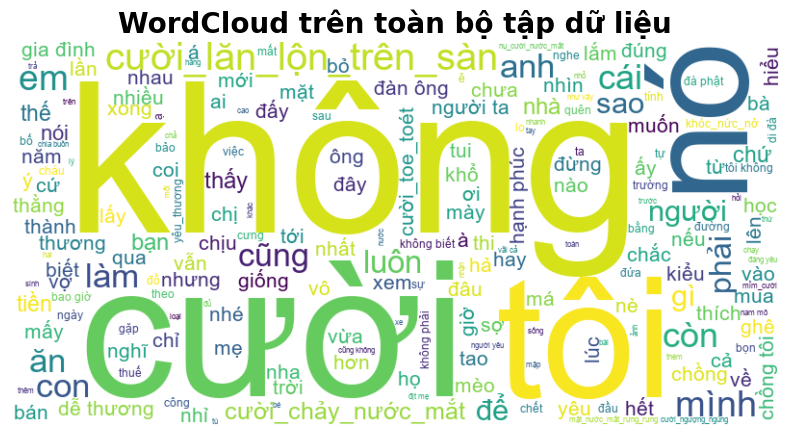

In [668]:
# Join lại
all_words = " ".join([" ".join(tokens) if isinstance(tokens, list) else tokens 
                     for tokens in preprocessed_hus_fb['Tokenized_Sentence']])
# Tạo WordCloud
wc = WordCloud(font_path='arial',
               background_color='white',
               width=800, height=400,
               colormap='viridis').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud trên toàn bộ tập dữ liệu",
          fontsize=20,
          fontweight='bold')
plt.show()

Nhận xét: Do enjoyment và icon nhiều nên chữ cười có tần suất xuất hiện nhiều nhất 

### Tần suất từ theo từng nhãn

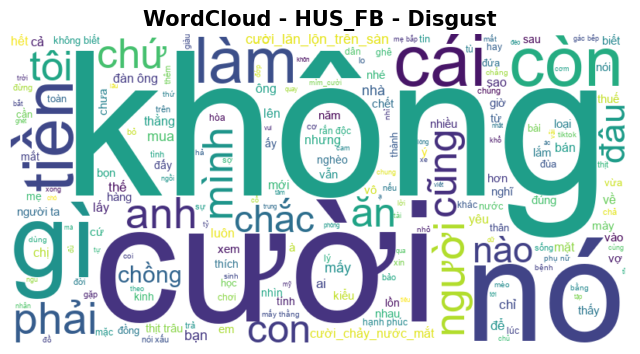

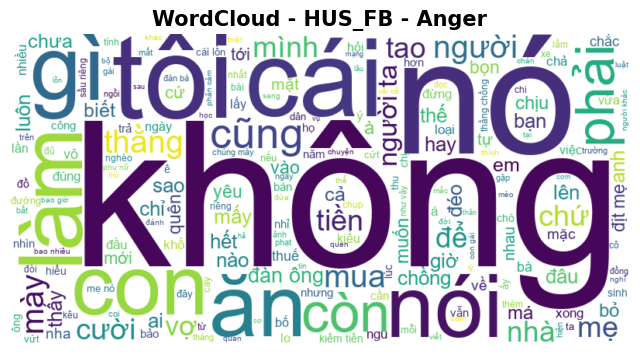

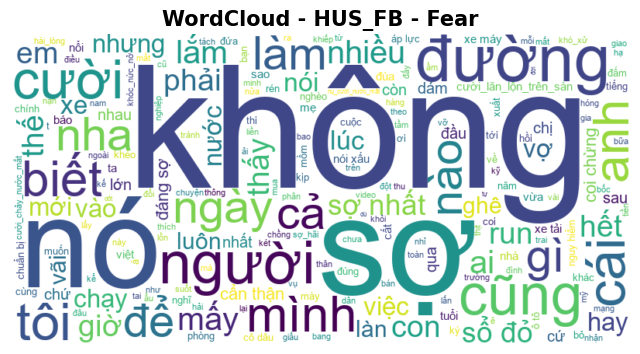

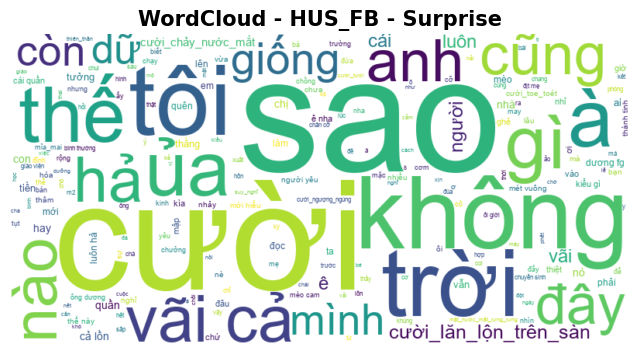

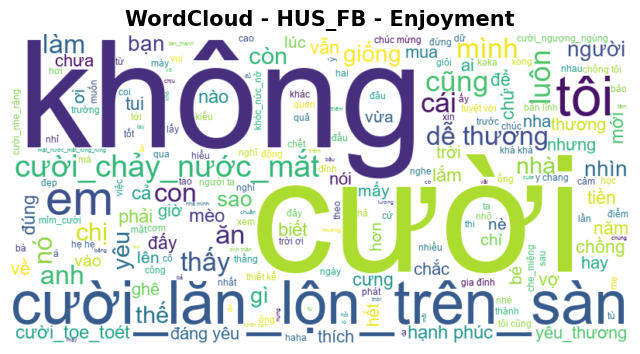

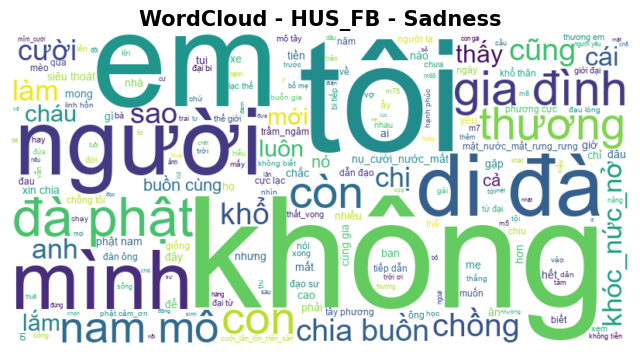

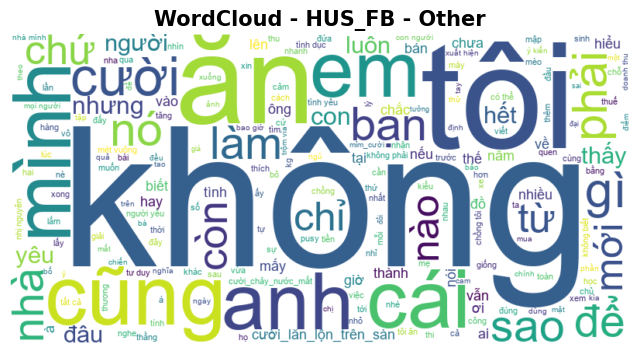

In [669]:
create_wordcloud_per_emotion(preprocessed_hus_fb, title_suffix="- HUS_FB")

### Phân bố số lượng token theo từng nhãn

THỐNG KÊ ĐỘ DÀI TOKEN THEO NHÃN
            count       mean        std  min  25%  50%   75%    max
Emotion                                                            
Anger       428.0  14.450935  18.088125  1.0  5.0  9.0  17.0  215.0
Disgust     616.0  10.243506  11.203765  1.0  5.0  8.0  12.0  181.0
Enjoyment  1756.0   7.034169   8.644282  1.0  3.0  5.0   8.0  197.0
Fear        123.0   8.934959   8.587772  1.0  4.0  6.0  10.5   53.0
Other       860.0   8.893023  11.563771  1.0  4.0  6.0  10.0  138.0
Sadness     445.0  10.395506  13.726445  1.0  4.0  7.0  12.0  175.0
Surprise    293.0   5.218430   3.674244  1.0  3.0  4.0   6.0   31.0


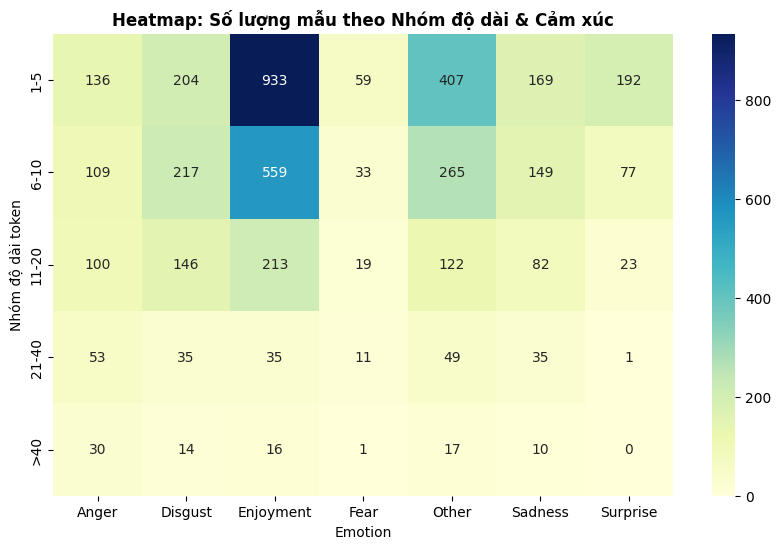

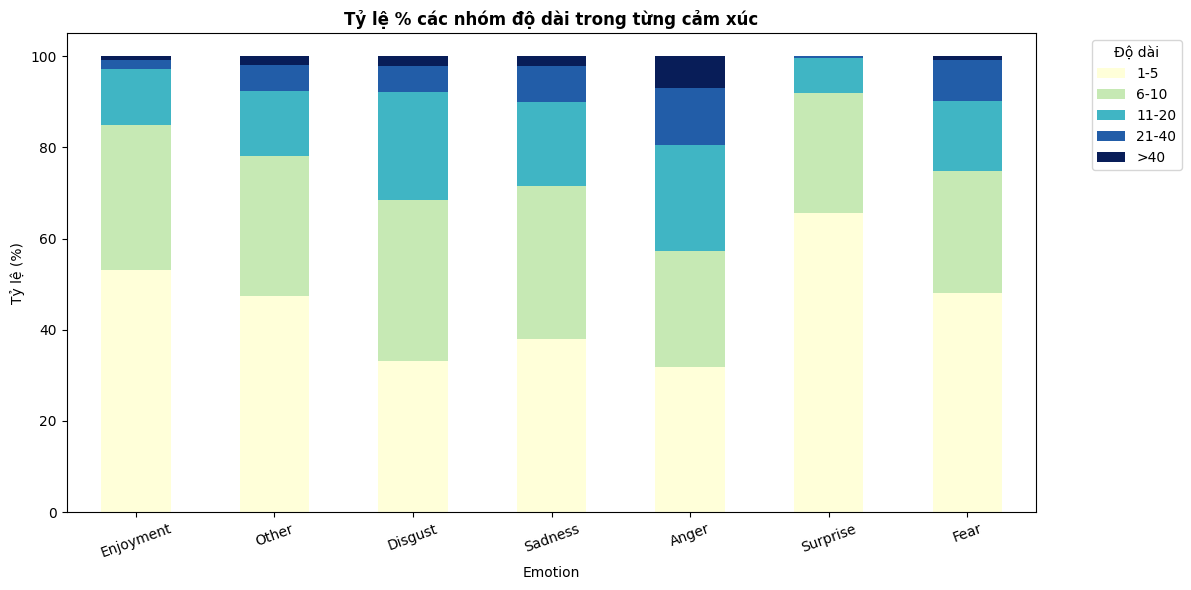

In [640]:
analyze_token_length_by_emotion(preprocessed_hus_fb)

### Phân tích từ vựng: N-grams và TF-IDF keywords

#### N-grams: Bigram & Trigram


Phân tích cho nhãn: Disgust


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


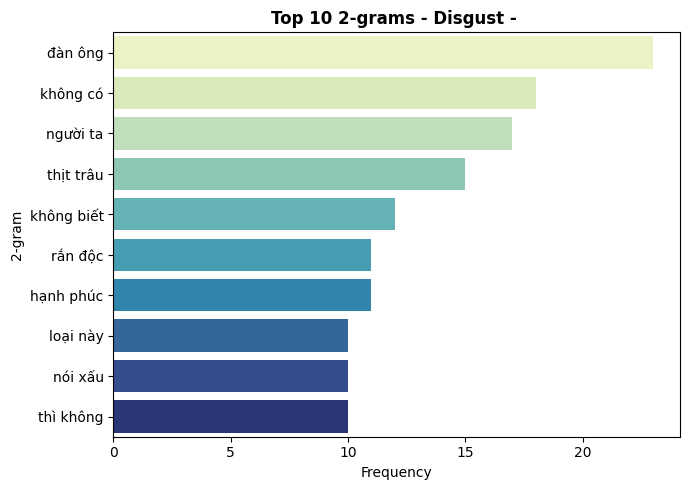

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


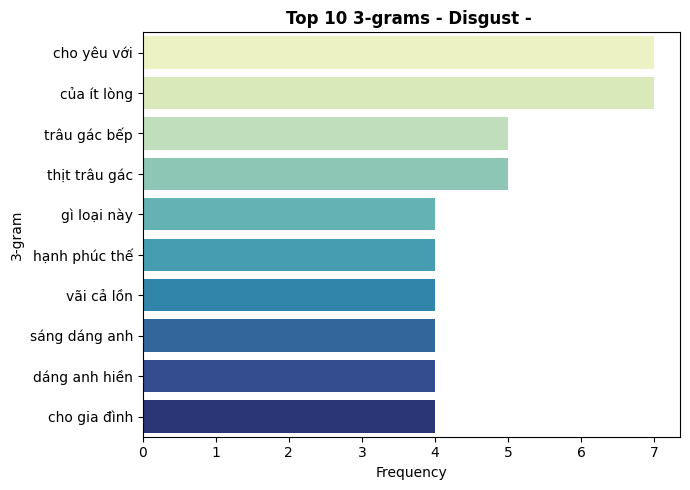


Phân tích cho nhãn: Anger


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


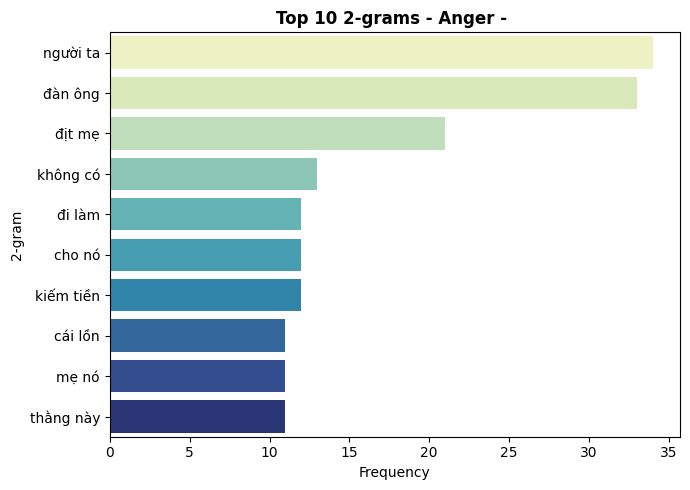

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


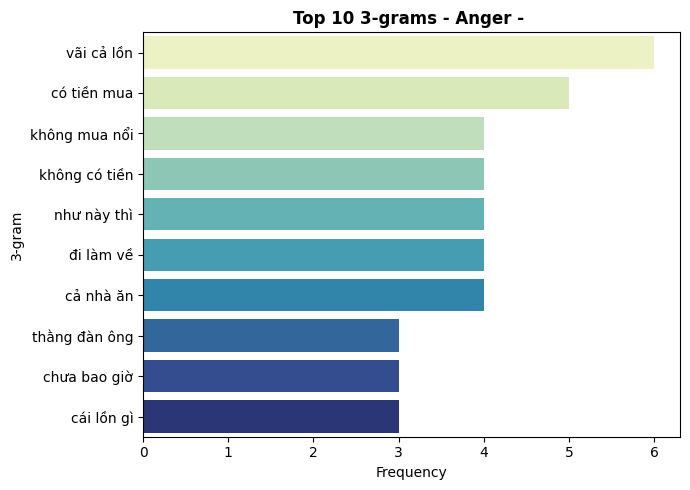


Phân tích cho nhãn: Fear


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


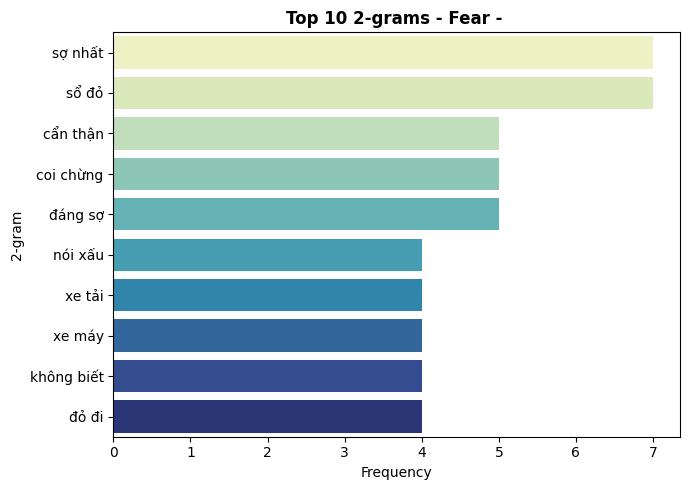

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


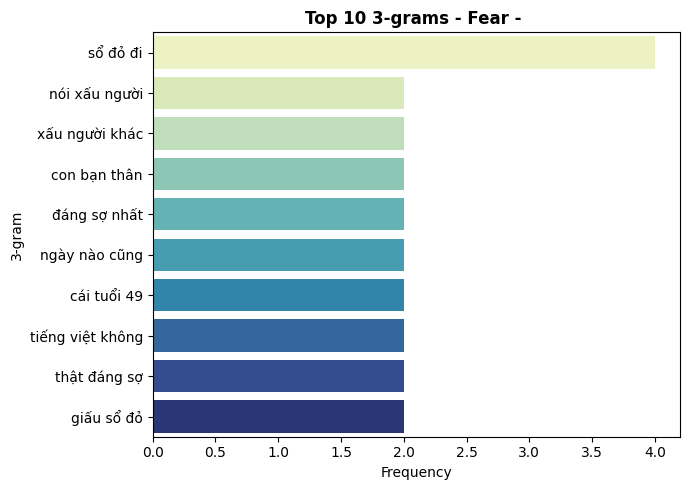


Phân tích cho nhãn: Surprise


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


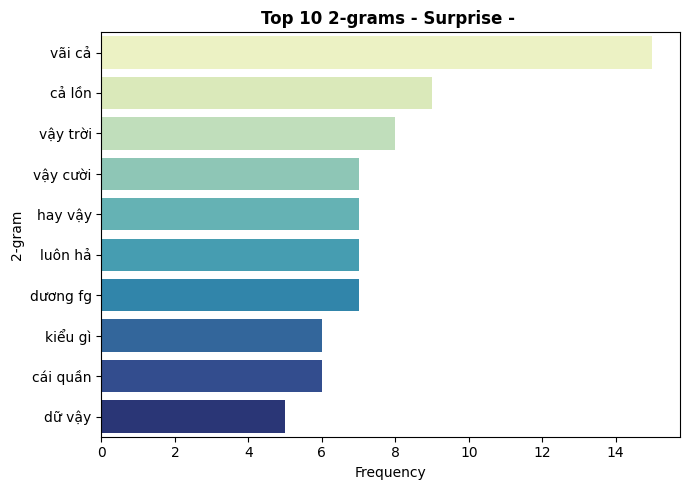

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


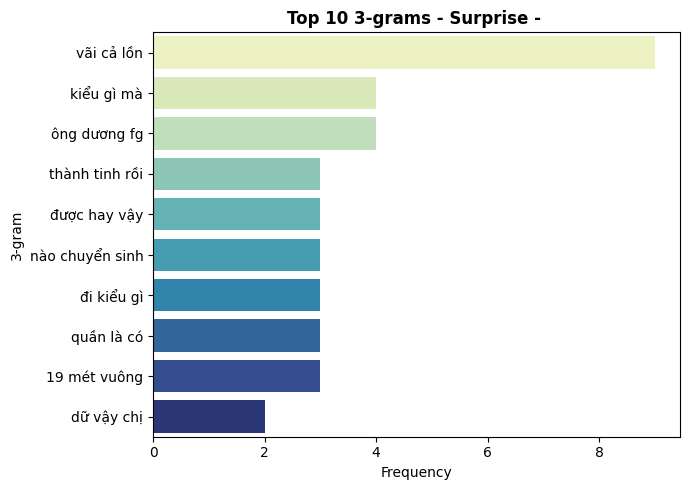


Phân tích cho nhãn: Enjoyment


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


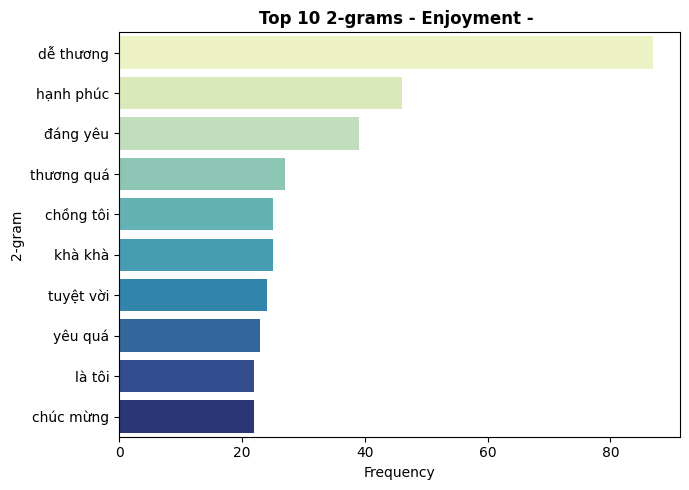

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


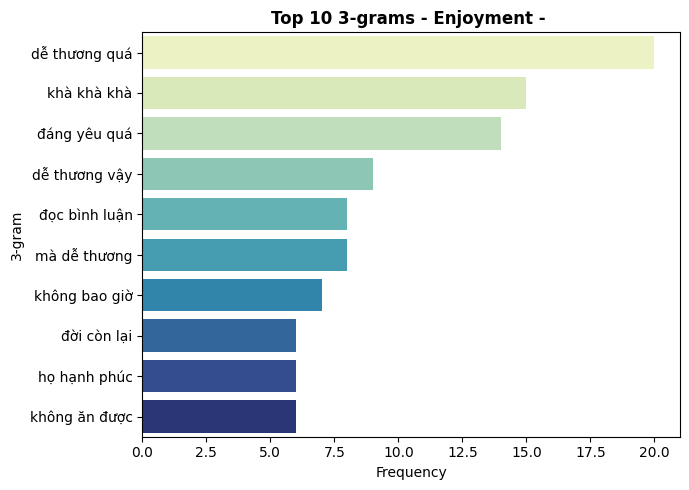


Phân tích cho nhãn: Sadness


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


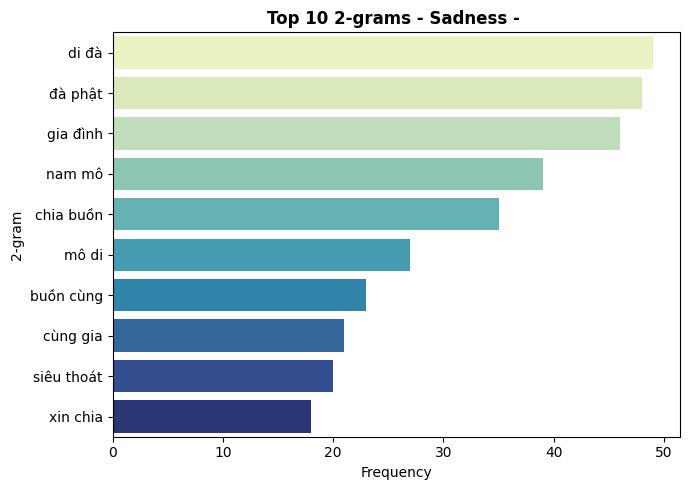

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


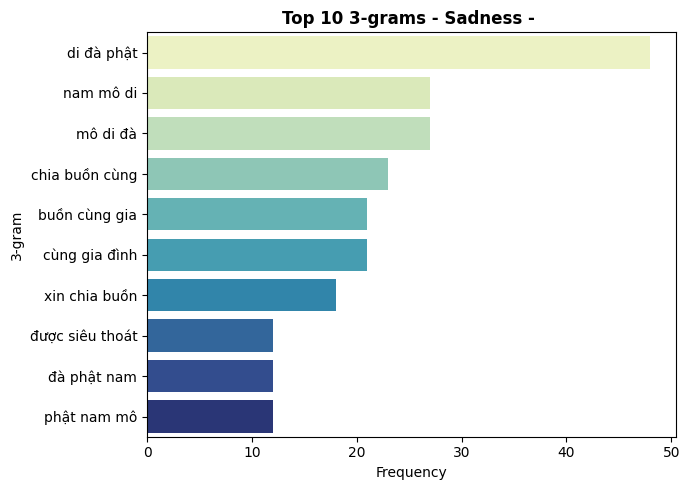


Phân tích cho nhãn: Other


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


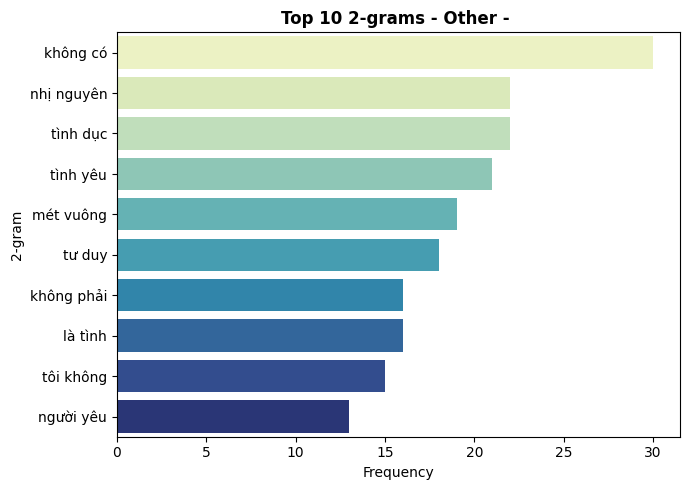

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


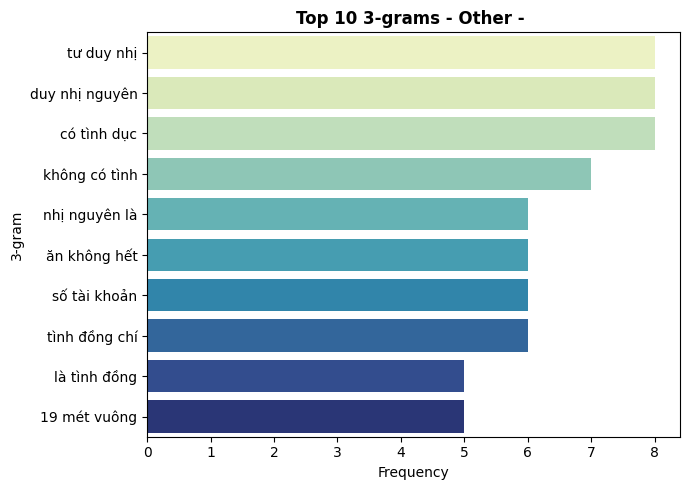

In [641]:
analyze_ngrams_per_emotion(preprocessed_hus_fb)

#### TF-IDF keysword

In [642]:
analyze_tfidf_per_emotion(preprocessed_hus_fb)

TOP TỪ KHÓA ĐẶC TRƯNG (TF-IDF) CHO TỪNG NHÃN

Label: ANGER
  - không: 0.2830
  - thì: 0.2320
  - nó: 0.1951
  - cho: 0.1846
  - mà: 0.1811

Label: DISGUST
  - không: 0.3224
  - là: 0.2298
  - thì: 0.2242
  - này: 0.2149
  - cười: 0.2020

Label: ENJOYMENT
  - cười: 0.3065
  - không: 0.2715
  - tôi: 0.2338
  - cười_lăn_lộn_trên_sàn: 0.2246
  - là: 0.1960

Label: FEAR
  - không: 0.3444
  - sợ: 0.3346
  - đi: 0.2067
  - đường: 0.1785
  - nó: 0.1771

Label: OTHER
  - không: 0.4154
  - là: 0.2861
  - có: 0.2498
  - tôi: 0.2324
  - thì: 0.1874

Label: SADNESS
  - di đà: 0.2339
  - di: 0.2339
  - đà phật: 0.2291
  - không: 0.2240
  - tôi: 0.2140

Label: SURPRISE
  - vậy: 0.3650
  - sao: 0.2351
  - mà: 0.2103
  - cười: 0.2041
  - là: 0.1794


# So sánh 2 bộ dữ liệu - gộp lại cho đẹp :<

In [643]:
print("=" * 50)
print("SO SÁNH TỔNG QUAN: UIT-VSMEC vs HUS_FB")
print("=" * 50)

comparison_summary = pd.DataFrame({
    'Metric': ['Tổng số mẫu', 'Số nhãn', 'Nhãn nhiều nhất', 'Nhãn ít nhất', 
               'Max/Min Ratio', 'Mean tokens', 'Median tokens', 'Max tokens'],
    'UIT-VSMEC': [
        len(preprocessed_uit),
        preprocessed_uit['Emotion'].nunique(),
        preprocessed_uit['Emotion'].value_counts().index[0],
        preprocessed_uit['Emotion'].value_counts().index[-1],
        f"{preprocessed_uit['Emotion'].value_counts().max() / preprocessed_uit['Emotion'].value_counts().min():.2f}",
        f"{preprocessed_uit['tokens_length'].mean():.2f}",
        f"{preprocessed_uit['tokens_length'].median():.1f}",
        f"{preprocessed_uit['tokens_length'].max()}"
    ],
    'HUS_FB': [
        len(preprocessed_hus_fb),
        preprocessed_hus_fb['Emotion'].nunique(),
        preprocessed_hus_fb['Emotion'].value_counts().index[0],
        preprocessed_hus_fb['Emotion'].value_counts().index[-1],
        f"{preprocessed_hus_fb['Emotion'].value_counts().max() / preprocessed_hus_fb['Emotion'].value_counts().min():.2f}",
        f"{preprocessed_hus_fb['tokens_length'].mean():.2f}",
        f"{preprocessed_hus_fb['tokens_length'].median():.1f}",
        f"{preprocessed_hus_fb['tokens_length'].max()}"
    ]
})

comparison_summary

SO SÁNH TỔNG QUAN: UIT-VSMEC vs HUS_FB


Metric  UIT-VSMEC     HUS_FB
0      Tổng số mẫu       6183       4521
1          Số nhãn          7          7
2  Nhãn nhiều nhất  Enjoyment  Enjoyment
3     Nhãn ít nhất   Surprise       Fear
4    Max/Min Ratio       6.50      14.28
5      Mean tokens       9.55       8.79
6    Median tokens        8.0        6.0
7       Max tokens        108        215

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\2354972936.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotion', data=preprocessed_uit, order=order_uit,
C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\2354972936.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotion', data=preprocessed_hus_fb, order=order_hus,


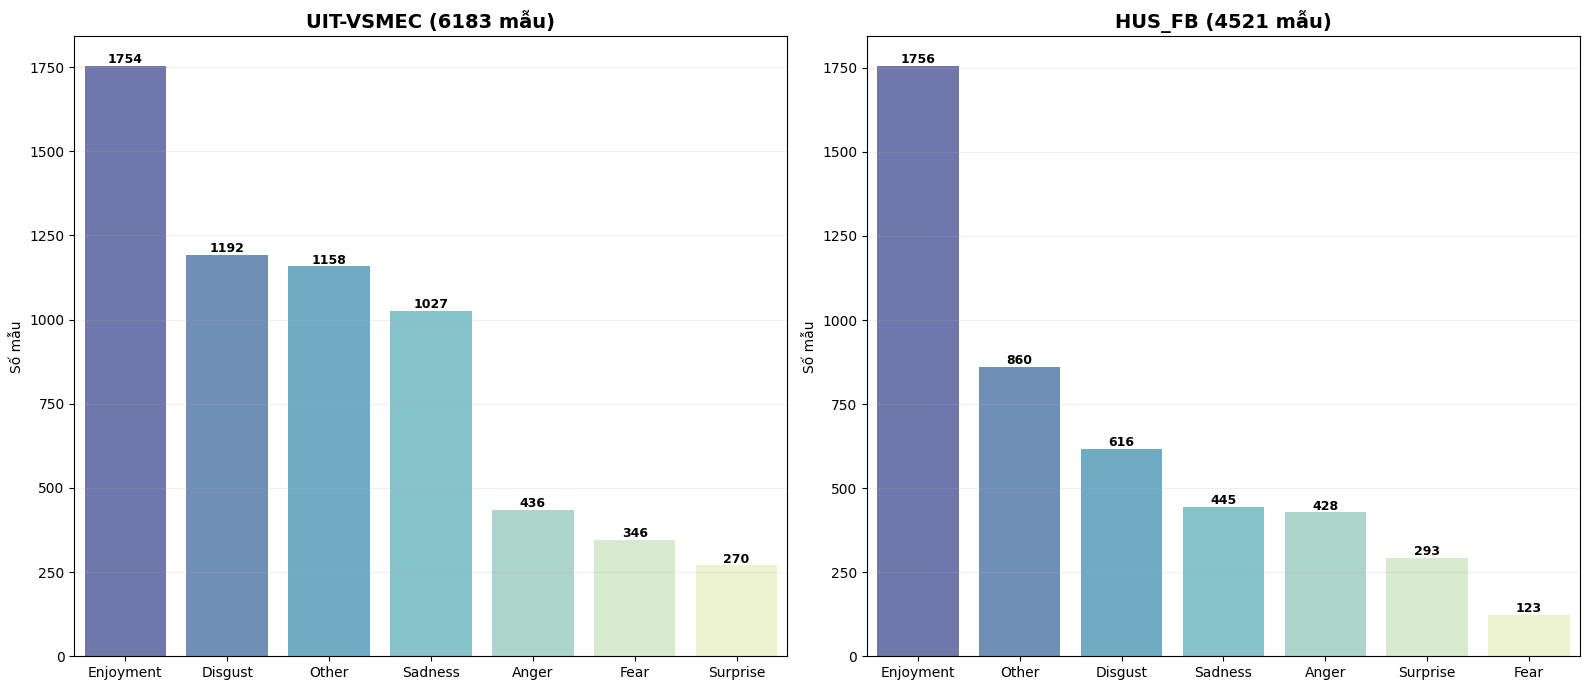

In [644]:
# SO SÁNH PHÂN BỐ NHÃN (SIDE-BY-SIDE)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# UIT-VSMEC
order_uit = preprocessed_uit['Emotion'].value_counts().index
colors_uit = sns.color_palette('YlGnBu_r', len(order_uit))
sns.countplot(x='Emotion', data=preprocessed_uit, order=order_uit, 
              palette=colors_uit, ax=axes[0], alpha=0.7)
axes[0].set_title(f'UIT-VSMEC ({len(preprocessed_uit)} mẫu)', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Số mẫu')
axes[0].set_xlabel('')
axes[0].grid(axis='y', alpha=0.2)
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height + 8, 
                 f'{int(height)}', ha="center", fontsize=9, fontweight='bold')

# HUS_FB
order_hus = preprocessed_hus_fb['Emotion'].value_counts().index
colors_hus = sns.color_palette('YlGnBu_r', len(order_hus))
sns.countplot(x='Emotion', data=preprocessed_hus_fb, order=order_hus, 
              palette=colors_hus, ax=axes[1], alpha=0.7)
axes[1].set_title(f'HUS_FB ({len(preprocessed_hus_fb)} mẫu)', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Số mẫu')
axes[1].set_xlabel('')
axes[1].grid(axis='y', alpha=0.2)
for p in axes[1].patches:
    height = p.get_height()
    axes[1].text(p.get_x() + p.get_width() / 2., height + 8, 
                 f'{int(height)}', ha="center", fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

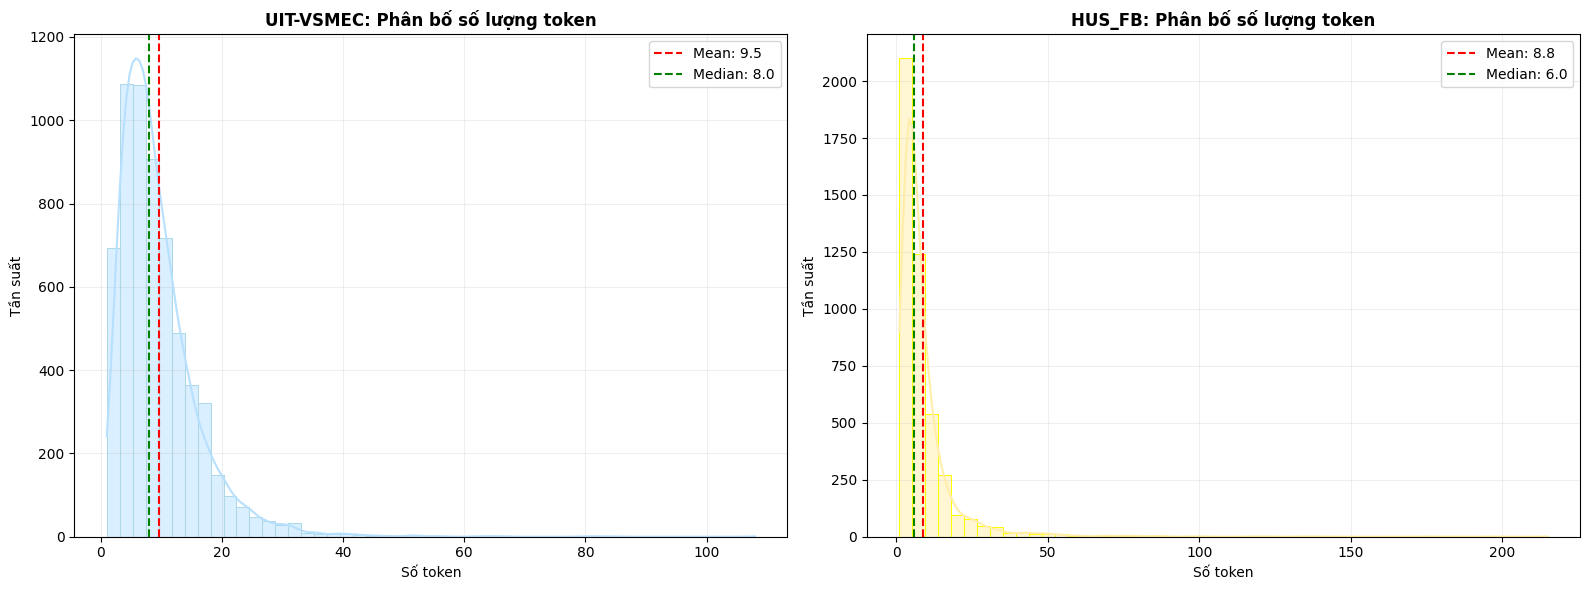

In [645]:
# SO SÁNH PHÂN BỐ ĐỘ DÀI TOKEN
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# UIT-VSMEC
sns.histplot(preprocessed_uit['tokens_length'], bins=50, kde=True, 
             edgecolor='lightblue', ax=axes[0], color='#B7E0FF')
axes[0].set_title('UIT-VSMEC: Phân bố số lượng token', fontweight='bold')
axes[0].set_xlabel('Số token')
axes[0].set_ylabel('Tần suất')
axes[0].grid(alpha=0.2)
axes[0].axvline(preprocessed_uit['tokens_length'].mean(), color='red', 
                linestyle='--', label=f'Mean: {preprocessed_uit["tokens_length"].mean():.1f}')
axes[0].axvline(preprocessed_uit['tokens_length'].median(), color='green', 
                linestyle='--', label=f'Median: {preprocessed_uit["tokens_length"].median():.1f}')
axes[0].legend()

# HUS_FB
sns.histplot(preprocessed_hus_fb['tokens_length'], bins=50, kde=True, 
             edgecolor='yellow', ax=axes[1], color='#FFEEA9')
axes[1].set_title('HUS_FB: Phân bố số lượng token', fontweight='bold')
axes[1].set_xlabel('Số token')
axes[1].set_ylabel('Tần suất')
axes[1].grid(alpha=0.2)
axes[1].axvline(preprocessed_hus_fb['tokens_length'].mean(), color='red', 
                linestyle='--', label=f'Mean: {preprocessed_hus_fb["tokens_length"].mean():.1f}')
axes[1].axvline(preprocessed_hus_fb['tokens_length'].median(), color='green', 
                linestyle='--', label=f'Median: {preprocessed_hus_fb["tokens_length"].median():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

SO SÁNH THỐNG KÊ ĐỘ DÀI TOKEN THEO NHÃN
  Emotion  UIT_Mean  HUS_Mean  UIT_Median  HUS_Median  UIT_Max  HUS_Max  Mean_Diff
    Anger     12.79     14.45        11.0         9.0       67      215       1.66
  Disgust     11.31     10.24         9.0         8.0      108      181      -1.07
     Fear     10.77      8.93         8.5         6.0       50       53      -1.84
  Sadness      9.44     10.40         8.0         7.0       34      175       0.96
Enjoyment      8.70      7.03         7.0         5.0       64      197      -1.67
    Other      8.25      8.89         7.0         6.0       41      138       0.64
 Surprise      6.46      5.22         6.0         4.0       20       31      -1.24


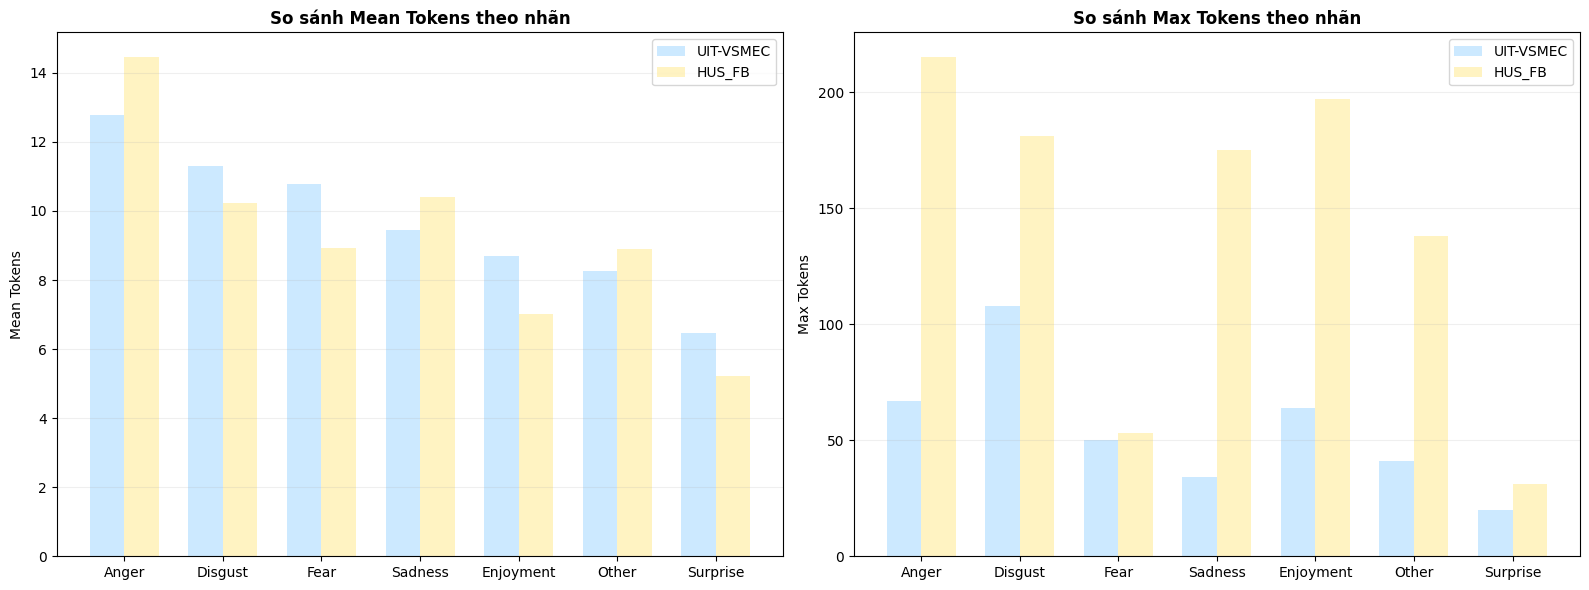

In [646]:
# Chưa hiểu cái biểu đồ bên dưới dùng để làm gì :))
# SO SÁNH THỐNG KÊ ĐỘ DÀI THEO TỪNG NHÃN
# Tính thống kê cho cả 2 bộ
stats_uit = preprocessed_uit.groupby('Emotion')['tokens_length'].agg(['mean', 'std', 'median', 'max']).round(2)
stats_hus = preprocessed_hus_fb.groupby('Emotion')['tokens_length'].agg(['mean', 'std', 'median', 'max']).round(2)

# Gộp lại để so sánh
comparison_stats = pd.DataFrame({
    'Emotion': stats_uit.index,
    'UIT_Mean': stats_uit['mean'].values,
    'HUS_Mean': stats_hus['mean'].values,
    'UIT_Median': stats_uit['median'].values,
    'HUS_Median': stats_hus['median'].values,
    'UIT_Max': stats_uit['max'].values,
    'HUS_Max': stats_hus['max'].values,
})

comparison_stats['Mean_Diff'] = (comparison_stats['HUS_Mean'] - comparison_stats['UIT_Mean']).round(2)
comparison_stats = comparison_stats.sort_values('UIT_Mean', ascending=False)

print("SO SÁNH THỐNG KÊ ĐỘ DÀI TOKEN THEO NHÃN")
print(comparison_stats.to_string(index=False))

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Mean tokens
x = np.arange(len(comparison_stats))
width = 0.35
axes[0].bar(x - width/2, comparison_stats['UIT_Mean'], width, label='UIT-VSMEC', alpha=0.7, color='#B7E0FF')
axes[0].bar(x + width/2, comparison_stats['HUS_Mean'], width, label='HUS_FB', alpha=0.7, color='#FFEEA9')
axes[0].set_xlabel('')
axes[0].set_ylabel('Mean Tokens')
axes[0].set_title('So sánh Mean Tokens theo nhãn', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_stats['Emotion'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.2)

# Max tokens
axes[1].bar(x - width/2, comparison_stats['UIT_Max'], width, label='UIT-VSMEC', alpha=0.7, color='#B7E0FF')
axes[1].bar(x + width/2, comparison_stats['HUS_Max'], width, label='HUS_FB', alpha=0.7, color='#FFEEA9')
axes[1].set_xlabel('')
axes[1].set_ylabel('Max Tokens')
axes[1].set_title('So sánh Max Tokens theo nhãn', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_stats['Emotion'])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()

SO SÁNH TỶ LỆ PHÂN BỐ NHÃN
  Emotion  UIT-VSMEC (%)  HUS_FB (%)  Difference (%)
Enjoyment          28.37       38.84           10.47
  Disgust          19.28       13.63           -5.65
    Other          18.73       19.02            0.29
  Sadness          16.61        9.84           -6.77
    Anger           7.05        9.47            2.42
     Fear           5.60        2.72           -2.88
 Surprise           4.37        6.48            2.11


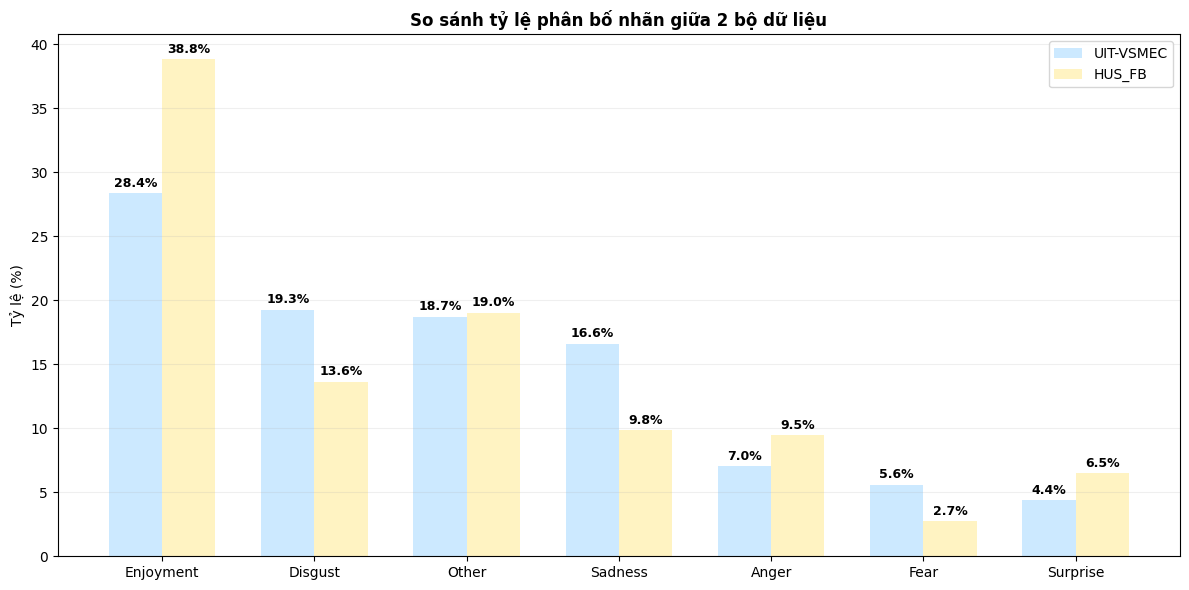

In [647]:
# SO SÁNH TỶ LỆ PHÂN BỐ NHÃN (%)
# Tính tỷ lệ %
order_uit = preprocessed_uit['Emotion'].value_counts().index

uit_percent = preprocessed_uit['Emotion'].value_counts(normalize=True).reindex(order_uit) * 100
hus_percent = preprocessed_hus_fb['Emotion'].value_counts(normalize=True).reindex(order_uit) * 100

percent_comparison = pd.DataFrame({
    'Emotion': uit_percent.index,
    'UIT-VSMEC (%)': uit_percent.values.round(2),
    'HUS_FB (%)': hus_percent.values.round(2),
    'Difference (%)': (hus_percent.values - uit_percent.values).round(2)
})

print("SO SÁNH TỶ LỆ PHÂN BỐ NHÃN")
print(percent_comparison.to_string(index=False))

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(percent_comparison))
width = 0.35
ax.bar(x - width/2, percent_comparison['UIT-VSMEC (%)'], width, 
       label='UIT-VSMEC', alpha=0.7, color='#B7E0FF')
ax.bar(x + width/2, percent_comparison['HUS_FB (%)'], width, 
       label='HUS_FB', alpha=0.7, color='#FFEEA9')
# ax.set_xlabel('Emotion')
ax.set_ylabel('Tỷ lệ (%)')
ax.set_title('So sánh tỷ lệ phân bố nhãn giữa 2 bộ dữ liệu', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(percent_comparison['Emotion'])
ax.legend()
ax.grid(axis='y', alpha=0.2)

# Thêm số liệu trên cột
for i, (uit_val, hus_val) in enumerate(zip(percent_comparison['UIT-VSMEC (%)'], 
                                            percent_comparison['HUS_FB (%)'])):
    ax.text(i - width/2, uit_val + 0.5, f'{uit_val:.1f}%', 
            ha='center', fontsize=9, fontweight='bold')
    ax.text(i + width/2, hus_val + 0.5, f'{hus_val:.1f}%', 
            ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

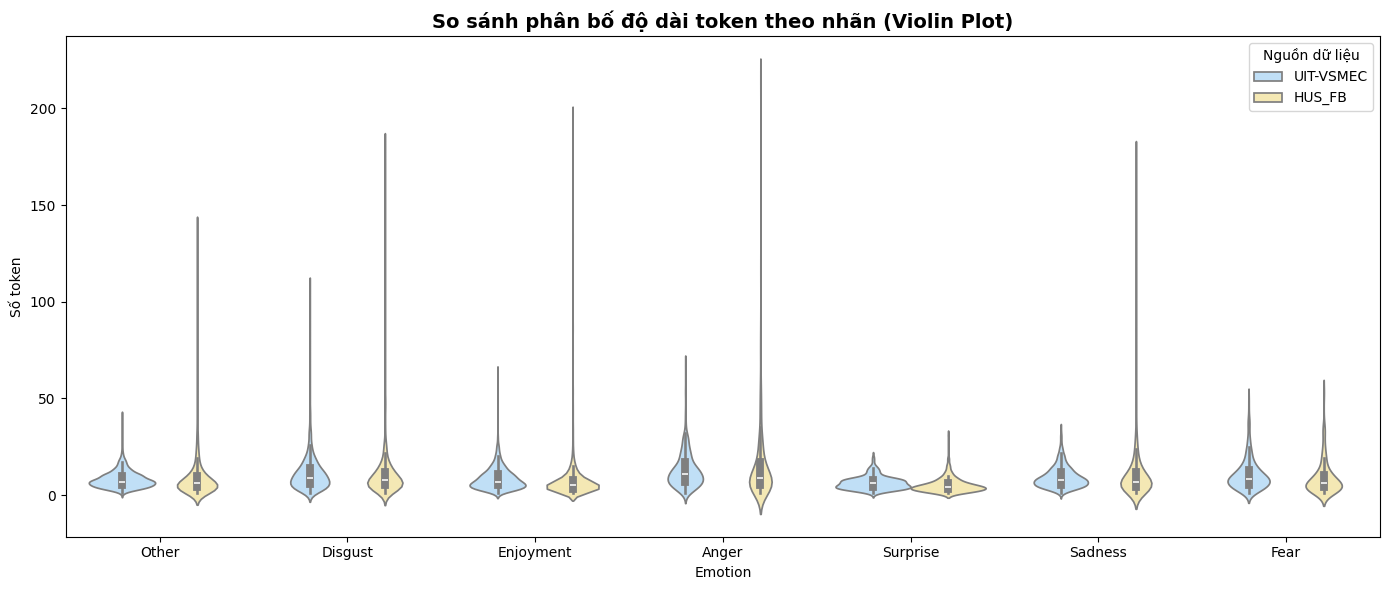

In [648]:
# SO SÁNH VIOLIN PLOT ĐỘ DÀI TOKEN
# Thêm cột nguồn dữ liệu
preprocessed_uit_copy = preprocessed_uit.copy()
preprocessed_uit_copy['Source'] = 'UIT-VSMEC'
preprocessed_hus_fb_copy = preprocessed_hus_fb.copy()
preprocessed_hus_fb_copy['Source'] = 'HUS_FB'

# Gộp lại
combined_df = pd.concat([preprocessed_uit_copy[['Emotion', 'tokens_length', 'Source']], 
                         preprocessed_hus_fb_copy[['Emotion', 'tokens_length', 'Source']]], 
                        ignore_index=True)

# Vẽ violin plot
fig, ax = plt.subplots(figsize=(14, 6))
sns.violinplot(x='Emotion', y='tokens_length', hue='Source', data=combined_df, 
               palette={'UIT-VSMEC': '#B7E0FF', 'HUS_FB': '#FFEEA9'}, ax=ax)
ax.set_title('So sánh phân bố độ dài token theo nhãn (Violin Plot)', fontweight='bold', fontsize=14)
ax.set_xlabel('Emotion')
ax.set_ylabel('Số token')
ax.legend(title='Nguồn dữ liệu')
plt.tight_layout()
plt.show()

In [662]:
# TỔNG HỢP
detailed_comparison = []

for emotion in sorted(preprocessed_uit['Emotion'].unique()):
    uit_data = preprocessed_uit[preprocessed_uit['Emotion'] == emotion]
    hus_data = preprocessed_hus_fb[preprocessed_hus_fb['Emotion'] == emotion]
    
    detailed_comparison.append({
        'Emotion': emotion,
        'UIT_Count': len(uit_data),
        'HUS_Count': len(hus_data),
        'UIT_%': f"{(len(uit_data)/len(preprocessed_uit)*100):.2f}%",
        'HUS_%': f"{(len(hus_data)/len(preprocessed_hus_fb)*100):.2f}%",
        'UIT_Mean_Tokens': f"{uit_data['tokens_length'].mean():.2f}",
        'HUS_Mean_Tokens': f"{hus_data['tokens_length'].mean():.2f}",
        'UIT_Max_Tokens': uit_data['tokens_length'].max(),
        'HUS_Max_Tokens': hus_data['tokens_length'].max(),
    })

comparison_df = pd.DataFrame(detailed_comparison)
comparison_df

Emotion  UIT_Count  HUS_Count   UIT_%   HUS_% UIT_Mean_Tokens  \
0      Anger        436        428   7.05%   9.47%           12.79   
1    Disgust       1192        616  19.28%  13.63%           11.31   
2  Enjoyment       1754       1756  28.37%  38.84%            8.70   
3       Fear        346        123   5.60%   2.72%           10.77   
4      Other       1158        860  18.73%  19.02%            8.25   
5    Sadness       1027        445  16.61%   9.84%            9.44   
6   Surprise        270        293   4.37%   6.48%            6.46   

  HUS_Mean_Tokens  UIT_Max_Tokens  HUS_Max_Tokens  
0           14.45              67             215  
1           10.24             108             181  
2            7.03              64             197  
3            8.93              50              53  
4            8.89              41             138  
5           10.40              34             175  
6            5.22              20              31

# Loại bỏ Outlier của HUS_FB

Dựa trên số lượng max_tokens_length của UIT,  nhóm quyết định lọc bộ dữ liệu HUS_FB, chỉ giữ lại những câu có độ dài token không quá 110

In [672]:
# Tính Q1, Q3 và IQR
Q1 = preprocessed_hus_fb['tokens_length'].quantile(0.25)    
Q3 = preprocessed_hus_fb['tokens_length'].quantile(0.75)

IQR = Q3 - Q1

# Tính giới hạn trên, dưới
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 = {Q1}, Q3 = {Q3}, IQR = {IQR}")
print(f"Ngưỡng dưới: {lower_bound}, ngưỡng trên: {upper_bound}")

Q1 = 4.0, Q3 = 10.0, IQR = 6.0
Ngưỡng dưới: -5.0, ngưỡng trên: 19.0


ngưỡng trên là 19, nhưng mà muốn model có thể nhận biết được cả những câu dài nữa :<

In [673]:
preprocessed_hus_fb['tokens_length'].quantile(0.99)

# 99% dữ liệu có số token <= 53

np.float64(53.0)

In [674]:
# cập nhật upper_bound
upper_bound = 110

In [675]:
# Loại bỏ các mẫu có số token > upper_bound
preprocessed_hus_fb_filter = preprocessed_hus_fb[preprocessed_hus_fb['tokens_length'] <= upper_bound]
print("Số lượng dòng loại bỏ sau khi loại bỏ outlier:", preprocessed_hus_fb[preprocessed_hus_fb['tokens_length'] > upper_bound].shape[0])
print("Phân trăm dòng loại bỏ:", (preprocessed_hus_fb[preprocessed_hus_fb['tokens_length'] > upper_bound].shape[0] / preprocessed_hus_fb.shape[0]) * 100, "%")
print("Kích thước bộ dữ liệu sau khi loại bỏ outlier:", preprocessed_hus_fb_filter.shape)

Số lượng dòng loại bỏ sau khi loại bỏ outlier: 9
Phân trăm dòng loại bỏ: 0.19907100199071004 %
Kích thước bộ dữ liệu sau khi loại bỏ outlier: (4512, 4)


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\936611338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocessed_hus_fb_filter['tokens_length'] = preprocessed_hus_fb_filter['Tokenized_Sentence'].apply(lambda x: len(x))


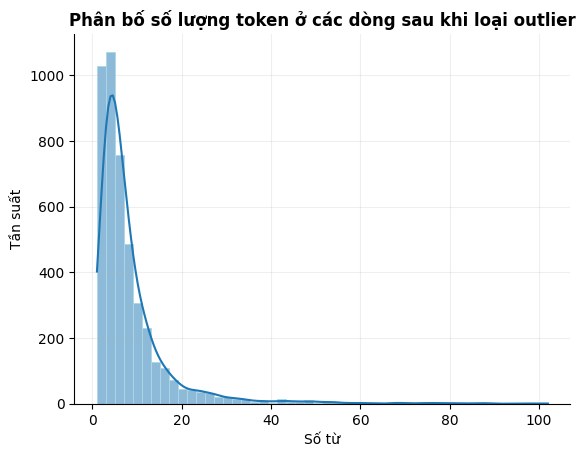

In [676]:
# Vẽ lại phân bố sau loại bỏ 
preprocessed_hus_fb_filter['tokens_length'] = preprocessed_hus_fb_filter['Tokenized_Sentence'].apply(lambda x: len(x))

sns.histplot(preprocessed_hus_fb_filter['tokens_length'], bins=50, edgecolor = 'lightblue', kde=True)    # bins: kc cách đều
sns.despine(top=True, right=True)
plt.title("Phân bố số lượng token ở các dòng sau khi loại outlier", fontweight = 'bold')
plt.xlabel("Số từ")
plt.ylabel("Tần suất")
plt.grid(alpha = 0.2)
plt.show()

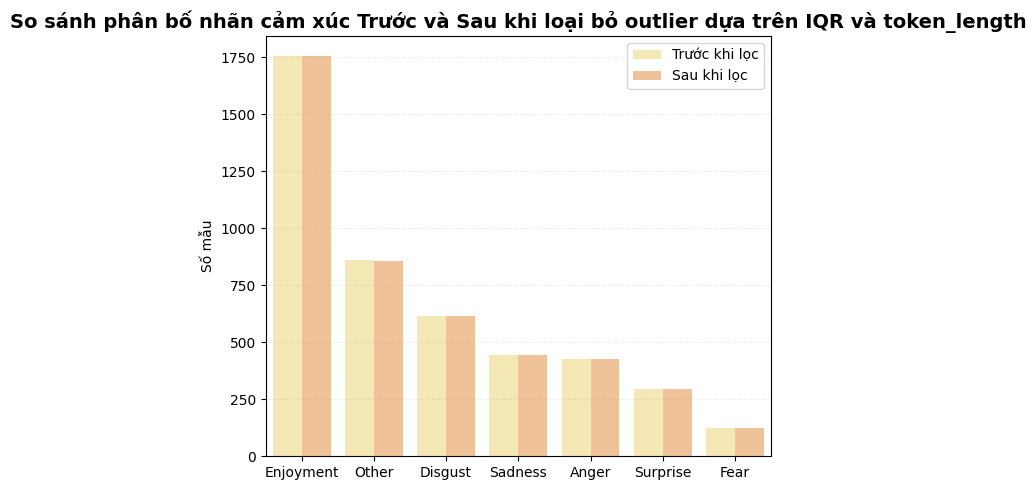

In [677]:
# 1. Chuẩn bị dữ liệu: Gán nhãn để phân biệt và gộp lại
# Tạo bản sao nhẹ để không ảnh hưởng dữ liệu gốc
df_before = preprocessed_hus_fb[['Emotion']].copy()
df_before['Trạng thái'] = 'Trước khi lọc'

df_after = preprocessed_hus_fb_filter[['Emotion']].copy()
df_after['Trạng thái'] = 'Sau khi lọc'

# Gộp 2 dataframe lại thành 1 (Long format)
df_combined = pd.concat([df_before, df_after])

order_by_count = preprocessed_hus_fb['Emotion'].value_counts().index

plt.figure(figsize=(6, 5))

# Dùng 'hue' để tách cột theo trạng thái
sns.countplot(x='Emotion', 
              data=df_combined, 
              hue='Trạng thái', 
              order=order_by_count, 
              palette={'Trước khi lọc': "#FFEEA9",'Sau khi lọc': "#FEC288"},
              alpha=1)

plt.title('So sánh phân bố nhãn cảm xúc Trước và Sau khi loại bỏ outlier dựa trên IQR và token_length', fontweight='bold', fontsize=14)
plt.ylabel('Số mẫu')
# plt.xlabel('Emotion')
plt.grid(axis='y', alpha=0.2, linestyle='--')
plt.legend(title=None) # Tắt tiêu đề của chú thích cho gọn
plt.xlabel('')
plt.tight_layout()
plt.show()

# Gộp 2 bộ dữ liệu

`preprocessed_uit_vsmec` + `preprocessed_hus_fb_filter`

## Phân loại nhãn theo mức độ phổ biến

- Nhãn hiếm (chiếm ít nhất 25% trong UIT)
- Nhãn trung bình (chiếm từ 25% đến 75% trong UIT)
- Nhãn phổ biến (chiếm hơn 75% trong UIT)

In [678]:
# Xem trung bình số lượng các nhãn
print("Trung bình số lượng nhãn của uit_vsmec:", preprocessed_uit['Emotion'].value_counts().mean())
print("Trung bình số lượng nhãn của hus_fb:", preprocessed_hus_fb_filter['Emotion'].value_counts().mean())

Trung bình số lượng nhãn của uit_vsmec: 883.2857142857143
Trung bình số lượng nhãn của hus_fb: 644.5714285714286


In [679]:
# Tính tổng tích lũy số lượng mỗi nhãn từ uit, xếp theo sl giảm dần
uit_counts = preprocessed_uit['Emotion'].value_counts().sort_values(ascending=False)
total_samples = uit_counts.sum()

data_rows = []  #List chứa kết quả
cumulative_percent = 0

# Phân loại dựa trên tỷ trọng trong UIT-VSMEC
for emotion, count in uit_counts.items():
    percent = count / total_samples
    previous_cum = cumulative_percent
    cumulative_percent += percent
    
    # Logic phân loại (Common 25% - Medium 50% - Rare 25%)
    if previous_cum < 0.25:
        group = 'Common'
    elif previous_cum < 0.75:
        group = 'Medium'
    else:
        group = 'Rare'
        
    data_rows.append({
        'Emotion': emotion,
        'Count': count,
        'Percent': round(percent * 100, 2),
        'Cumulative': round(cumulative_percent * 100, 2),
        'Group': group
    })

df_classification = pd.DataFrame(data_rows)

df_classification

Emotion  Count  Percent  Cumulative   Group
0  Enjoyment   1754    28.37       28.37  Common
1    Disgust   1192    19.28       47.65  Medium
2      Other   1158    18.73       66.38  Medium
3    Sadness   1027    16.61       82.99  Medium
4      Anger    436     7.05       90.04    Rare
5       Fear    346     5.60       95.63    Rare
6   Surprise    270     4.37      100.00    Rare

In [680]:
rare_labels = df_classification[df_classification['Group'] == 'Rare']['Emotion'].tolist()      
medium_labels = df_classification[df_classification['Group'] == 'Medium']['Emotion'].tolist()    
common_labels = df_classification[df_classification['Group'] == 'Common']['Emotion'].tolist()  


print("PHÂN LOẠI NHÃN:")
print(f"\nNhãn hiếm: {rare_labels}")
print(f"Nhãn trung bình: {medium_labels}")
print(f"Nhãn phổ biến: {common_labels}")

PHÂN LOẠI NHÃN:

Nhãn hiếm: ['Anger', 'Fear', 'Surprise']
Nhãn trung bình: ['Disgust', 'Other', 'Sadness']
Nhãn phổ biến: ['Enjoyment']


## Gộp dữ liệu

In [681]:
sample_ratios = {
    'rare': 1.0,      # Lấy 100% cho nhãn hiếm
    'medium': 0.5,    # Lấy 50% cho nhãn trung bình
    'common': 0.25     # Lấy 25% cho nhãn phổ biến
}

merged_samples = []

# Lấy UIT-VSMEC (base dataset)
merged_samples.append(preprocessed_uit.copy())

# Lấy mẫu từ HUS_FB
for emotion in sorted(preprocessed_hus_fb_filter['Emotion'].unique()):
    hus_data = preprocessed_hus_fb_filter[preprocessed_hus_fb_filter['Emotion'] == emotion].copy()
    
    if emotion in rare_labels:
        # Nhãn hiếm: Lấy toàn bộ
        ratio = sample_ratios['rare']
        needed = int(len(hus_data) * ratio)
        sampled = hus_data.sample(n=needed, random_state=11) if needed > 0 else hus_data
        merged_samples.append(sampled)
        print(f"  {emotion:12s} (hiếm):    Lấy {len(sampled):4d}/{len(hus_data):4d} mẫu ({ratio*100:.0f}%)")
        
    elif emotion in medium_labels:
        # Nhãn trung bình: Lấy 50%
        ratio = sample_ratios['medium']
        needed = int(len(hus_data) * ratio)
        sampled = hus_data.sample(n=needed, random_state=11) if needed > 0 else hus_data
        merged_samples.append(sampled)
        print(f"  {emotion:12s} (trung bình): Lấy {len(sampled):4d}/{len(hus_data):4d} mẫu ({ratio*100:.0f}%)")
        
    else:  # common_labels
        # Nhãn phổ biến: Lấy 25%
        ratio = sample_ratios['common']
        needed = int(len(hus_data) * ratio)
        sampled = hus_data.sample(n=needed, random_state=11) if needed > 0 else hus_data
        merged_samples.append(sampled)
        print(f"  {emotion:12s} (phổ biến): Lấy {len(sampled):4d}/{len(hus_data):4d} mẫu ({ratio*100:.0f}%)")

# Gộp
merged_final = pd.concat(merged_samples, ignore_index=True)

# Xáo trộn để tránh thiên lệch
merged_final = merged_final.sample(frac=1, random_state=11).reset_index(drop=True)

  Anger        (hiếm):    Lấy  426/ 426 mẫu (100%)
  Disgust      (trung bình): Lấy  307/ 615 mẫu (50%)
  Enjoyment    (phổ biến): Lấy  438/1754 mẫu (25%)
  Fear         (hiếm):    Lấy  123/ 123 mẫu (100%)
  Other        (trung bình): Lấy  429/ 858 mẫu (50%)
  Sadness      (trung bình): Lấy  221/ 443 mẫu (50%)
  Surprise     (hiếm):    Lấy  293/ 293 mẫu (100%)


## Thống kê kết quả

In [682]:
# Kết quả
print("KẾT QUẢ SAU KHI GỘP:")
print(f"\nTổng số mẫu: {len(merged_final)}")
print(f"- Từ UIT-VSMEC: {len(preprocessed_uit)} mẫu")
print(f"- Từ HUS_FB: {len(merged_final) - len(preprocessed_uit)} mẫu")

print("\nPhân bố nhãn sau khi gộp:")
merged_counts = merged_final['Emotion'].value_counts().sort_index()
for emotion, count in merged_counts.items():
    print(f"{emotion:12s}: {count:4d} mẫu ({count/len(merged_final)*100:5.2f}%)")

print(f"\nĐộ mất cân bằng (Max/Min): {merged_counts.max() / merged_counts.min():.2f}")

KẾT QUẢ SAU KHI GỘP:

Tổng số mẫu: 8420
- Từ UIT-VSMEC: 6183 mẫu
- Từ HUS_FB: 2237 mẫu

Phân bố nhãn sau khi gộp:
Anger       :  862 mẫu (10.24%)
Disgust     : 1499 mẫu (17.80%)
Enjoyment   : 2192 mẫu (26.03%)
Fear        :  469 mẫu ( 5.57%)
Other       : 1587 mẫu (18.85%)
Sadness     : 1248 mẫu (14.82%)
Surprise    :  563 mẫu ( 6.69%)

Độ mất cân bằng (Max/Min): 4.67


In [683]:
print("\nSO SÁNH PHÂN BỐ:")

comparison_df = pd.DataFrame({
    'Emotion': sorted(labels_to_check),
    'UIT-VSMEC': [uit_counts.get(e, 0) for e in sorted(labels_to_check)],
    'HUS_FB (lấy)': [len(merged_final[merged_final['Emotion'] == e]) - uit_counts.get(e, 0) 
                     for e in sorted(labels_to_check)],
    'Sau gộp': [merged_counts.get(e, 0) for e in sorted(labels_to_check)],
    'UIT %': [f"{uit_counts.get(e, 0)/len(preprocessed_uit)*100:.2f}%" 
              for e in sorted(labels_to_check)],
    'Sau gộp %': [f"{merged_counts.get(e, 0)/len(merged_final)*100:.2f}%" 
                  for e in sorted(labels_to_check)],
})

comparison_df


SO SÁNH PHÂN BỐ:


Emotion  UIT-VSMEC  HUS_FB (lấy)  Sau gộp   UIT % Sau gộp %
0      Anger        436           426      862   7.05%    10.24%
1    Disgust       1192           307     1499  19.28%    17.80%
2  Enjoyment       1754           438     2192  28.37%    26.03%
3       Fear        346           123      469   5.60%     5.57%
4      Other       1158           429     1587  18.73%    18.85%
5    Sadness       1027           221     1248  16.61%    14.82%
6   Surprise        270           293      563   4.37%     6.69%

## Luu lai ket qua gop

In [684]:
# drop cột tokens_length trước khi lưu
merged_final = merged_final.drop(columns=['tokens_length'])

In [685]:
output_path = "../data/merged_data/merged_data.csv"
merged_final.to_csv(output_path, index=False, encoding='utf-8-sig')